# Auto lithofacies classification (unsupervised cluster analysis)

This notebook demonstrates how to read four CSV files (CT, RGB, MST, hi-res MS) for core M9907-22PC, merge them using a shared depth column, perform unsupervised K-Means clustering on selected log columns, and visualize the clustered intervals versus depth.

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import random
import matplotlib.collections as mcoll
from scipy import stats
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
# Resample each dataset to the common depth scale
from scipy.interpolate import interp1d

from scipy.signal import savgol_filter

# Setup: directories, config, file paths, columns

In [25]:
# Configuration dictionaries
data_config = {
    'mother_dir': '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/',
    'core_name': 'M9907-22PC',
    'core_length': 501,
    'data_folder': '_compiled_logs/M9907-22PC/',
    'clean_output_folder': '_compiled_logs/M9907-22PC/ML_clean/',
    'filled_output_folder': '_compiled_logs/M9907-22PC/ML_filled/',
    'thresholds': {
        'ms': ['>', 150, 1],
        'pwvel': ['>', 1085, 3],
        'den': ['<', 1, 1],
        'elecres': ['<', 0, 1],
        'hiresms': ['<=', 24, 1]
    }
}

core_name = data_config['core_name']
mother_dir = data_config['mother_dir']
core_length = data_config['core_length']
clean_output_folder = data_config['clean_output_folder']
filled_output_folder = data_config['filled_output_folder']

# Load CT and RGB images
ct_img_path = mother_dir + '_compiled_logs/' + core_name + '/' + core_name + '_CT.tiff'
rgb_img_path = mother_dir + '_compiled_logs/' + core_name + '/' + core_name + '_RGB.tiff'

ct_img = plt.imread(ct_img_path)
rgb_img = plt.imread(rgb_img_path)

# Configuration for log data column auto-selection within the functions
column_configs = {
    'ct': {
        'data_col': 'CT',
        'std_col': 'CT_std',
        'depth_col': 'SB_DEPTH_cm'
    },
    'rgb': {
        'data_cols': ['R', 'G', 'B', 'Lumin'],
        'std_cols': ['R_std', 'G_std', 'B_std', 'Lumin_std'],
        'depth_col': 'SB_DEPTH_cm'
    },
    'mst': {
        'density':  {'data_col': 'Den_gm/cc',    'depth_col': 'SB_DEPTH_cm'},
        'pwvel':    {'data_col': 'PWVel_m/s',    'depth_col': 'SB_DEPTH_cm'},
        'pwamp':    {'data_col': 'PWAmp',        'depth_col': 'SB_DEPTH_cm'},
        # 'elecres':  {'data_col': 'ElecRes_ohmm', 'depth_col': 'SB_DEPTH_cm'},
        'ms':       {'data_col': 'MS',           'depth_col': 'SB_DEPTH_cm'},
    },
    'hrms': {
        'data_col': 'hiresMS',
        'depth_col': 'SB_DEPTH_cm'
    }
}

# Paths to each CSV
clean_data_paths = {
    'ct': mother_dir + clean_output_folder + f'{core_name}_CT_clean.csv',
    'rgb': mother_dir + clean_output_folder + f'{core_name}_RGB_clean.csv', 
    'mst': mother_dir + clean_output_folder + f'{core_name}_MST_clean.csv',
    'hrms': mother_dir + clean_output_folder + f'{core_name}_hiresMS_clean.csv'
}

filled_data_paths = {
    'ct':  os.path.join(mother_dir, filled_output_folder, f'{core_name}_CT_MLfilled.csv'),
    'rgb': os.path.join(mother_dir, filled_output_folder, f'{core_name}_RGB_MLfilled.csv'),
    'mst': os.path.join(mother_dir, filled_output_folder, f'{core_name}_MST_MLfilled.csv'),
    'hrms':os.path.join(mother_dir, filled_output_folder, f'{core_name}_hiresMS_MLfilled.csv')
}

df_ct = pd.read_csv(filled_data_paths['ct'])
df_rgb = pd.read_csv(filled_data_paths['rgb'])
df_mst = pd.read_csv(filled_data_paths['mst'])
df_hrms = pd.read_csv(filled_data_paths['hrms'])

print("Shapes of loaded DataFrames:")
print("df_ct:", df_ct.shape)
print("df_rgb:", df_rgb.shape)
print("df_mst:", df_mst.shape)
print("df_hrms:", df_hrms.shape)

Shapes of loaded DataFrames:
df_ct: (49465, 4)
df_rgb: (4920, 10)
df_mst: (501, 10)
df_hrms: (492, 2)


# Extract and Rename Columns
Use the `column_configs` dictionary to subset and rename columns for each dataset, ensuring a consistent `'depth'` column.

In [26]:
# CT subset
ct_depth_col = column_configs['ct']['depth_col']
ct_data_col = column_configs['ct']['data_col']
ct_std_col = column_configs['ct']['std_col']
df_ct_subset = df_ct[[ct_depth_col, ct_data_col, ct_std_col]].copy()
df_ct_subset.rename(columns={
    ct_depth_col: 'depth',
    ct_data_col: 'CT',
    ct_std_col: 'CT_std'
}, inplace=True)

# RGB subset
rgb_depth_col = column_configs['rgb']['depth_col']
rgb_data_cols = column_configs['rgb']['data_cols']  # ['R','G','B','Lumin']
rgb_std_cols = column_configs['rgb']['std_cols']   # ['R_std','G_std','B_std','Lumin_std']
df_rgb_subset = df_rgb[[rgb_depth_col] + rgb_data_cols + rgb_std_cols].copy()
df_rgb_subset.rename(columns={
    rgb_depth_col: 'depth',
    'R': 'R', 'G': 'G', 'B': 'B', 'Lumin': 'Lumin',
    'R_std': 'R_std', 'G_std': 'G_std', 'B_std': 'B_std', 'Lumin_std': 'Lumin_std'
}, inplace=True)

# MST subset
mst_config = column_configs['mst']
mst_depth_col = mst_config['density']['depth_col']
mst_cols = [
    mst_config['density']['data_col'],
    mst_config['pwvel']['data_col'],
    mst_config['pwamp']['data_col'],
    # mst_config['elecres']['data_col'],
    mst_config['ms']['data_col']
]
df_mst_subset = df_mst[[mst_depth_col] + mst_cols].copy()
df_mst_subset.rename(columns={
    mst_depth_col: 'depth',
    mst_config['density']['data_col']:  'Density',
    mst_config['pwvel']['data_col']:    'PWVel',
    mst_config['pwamp']['data_col']:    'PWAmp',
    # mst_config['elecres']['data_col']:  'ElecRes',
    mst_config['ms']['data_col']:       'MS'
}, inplace=True)

# hi-res MS subset
hrms_depth_col = column_configs['hrms']['depth_col']
hrms_data_col  = column_configs['hrms']['data_col']
df_hrms_subset = df_hrms[[hrms_depth_col, hrms_data_col]].copy()
df_hrms_subset.rename(columns={
    hrms_depth_col: 'depth',
    hrms_data_col:  'hiresMS'
}, inplace=True)

# # Create a common depth scale based on hrms (high-resolution magnetic susceptibility)
# # Generate a depth scale with the same resolution as hiresMS
# min_depth = df_hrms_subset['depth'].min()
# max_depth = df_hrms_subset['depth'].max()
# # Calculate the average step size in the original hiresMS data
# avg_step = np.mean(np.diff(np.sort(df_hrms_subset['depth'].unique())))
# # Create new depth scale with the same resolution as hiresMS
# common_depths = np.arange(min_depth, max_depth + avg_step/4, avg_step/2)   #resample to 2x of the hiresMS depth resolution

# Create a common depth scale based on hrms (high-resolution magnetic susceptibility)
# Generate a depth scale with 2 times higher resolution than hiresMS
min_depth = df_hrms_subset['depth'].min()
max_depth = df_hrms_subset['depth'].max()
# Calculate the average step size in the original hiresMS data
avg_step = np.mean(np.diff(np.sort(df_hrms_subset['depth'].unique())))
# Create new depth scale with twice the resolution (half the step size)
common_depths = np.arange(min_depth, max_depth + avg_step/225, avg_step/15)  #resample to 10x of the hiresMS depth resolution

# CT data resampling
ct_interp = interp1d(df_ct_subset['depth'], df_ct_subset['CT'], 
                    bounds_error=False, fill_value=np.nan)
ct_std_interp = interp1d(df_ct_subset['depth'], df_ct_subset['CT_std'], 
                        bounds_error=False, fill_value=np.nan)

# RGB data resampling
r_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['R'], 
                   bounds_error=False, fill_value=np.nan)
g_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['G'], 
                   bounds_error=False, fill_value=np.nan)
b_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['B'], 
                   bounds_error=False, fill_value=np.nan)
lumin_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['Lumin'], 
                       bounds_error=False, fill_value=np.nan)
r_std_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['R_std'], 
                       bounds_error=False, fill_value=np.nan)
g_std_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['G_std'], 
                       bounds_error=False, fill_value=np.nan)
b_std_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['B_std'], 
                       bounds_error=False, fill_value=np.nan)
lumin_std_interp = interp1d(df_rgb_subset['depth'], df_rgb_subset['Lumin_std'], 
                           bounds_error=False, fill_value=np.nan)

# MST data resampling
density_interp = interp1d(df_mst_subset['depth'], df_mst_subset['Density'], 
                         bounds_error=False, fill_value=np.nan)
pwvel_interp = interp1d(df_mst_subset['depth'], df_mst_subset['PWVel'], 
                       bounds_error=False, fill_value=np.nan)
pwamp_interp = interp1d(df_mst_subset['depth'], df_mst_subset['PWAmp'], 
                       bounds_error=False, fill_value=np.nan)
ms_interp = interp1d(df_mst_subset['depth'], df_mst_subset['MS'], 
                    bounds_error=False, fill_value=np.nan)

# Get interpolated values
ct_values = ct_interp(common_depths)
ct_std_values = ct_std_interp(common_depths)
r_values = r_interp(common_depths)
g_values = g_interp(common_depths)
b_values = b_interp(common_depths)
lumin_values = lumin_interp(common_depths)
r_std_values = r_std_interp(common_depths)
g_std_values = g_std_interp(common_depths)
b_std_values = b_std_interp(common_depths)
lumin_std_values = lumin_std_interp(common_depths)
density_values = density_interp(common_depths)
pwvel_values = pwvel_interp(common_depths)
pwamp_values = pwamp_interp(common_depths)
ms_values = ms_interp(common_depths)

# Apply smoothing using a Savitzky-Golay filter
window_length = 5  # Must be odd number
polyorder = 3  # Polynomial order for fitting
edge_points = window_length // 2  # Number of points to keep unsmoothed at each edge

# Helper function to apply smoothing while preserving edges
def smooth_with_edges(data, window_length, polyorder):
    smoothed = savgol_filter(data, window_length, polyorder)
    # Keep original values at edges
    smoothed[:edge_points] = data[:edge_points]
    smoothed[-edge_points:] = data[-edge_points:]
    return smoothed

# Apply smoothing to all values
ct_values = smooth_with_edges(ct_values, window_length, polyorder)
ct_std_values = smooth_with_edges(ct_std_values, window_length, polyorder)
r_values = smooth_with_edges(r_values, window_length, polyorder)
g_values = smooth_with_edges(g_values, window_length, polyorder)
b_values = smooth_with_edges(b_values, window_length, polyorder)
lumin_values = smooth_with_edges(lumin_values, window_length, polyorder)
r_std_values = smooth_with_edges(r_std_values, window_length, polyorder)
g_std_values = smooth_with_edges(g_std_values, window_length, polyorder)
b_std_values = smooth_with_edges(b_std_values, window_length, polyorder)
lumin_std_values = smooth_with_edges(lumin_std_values, window_length, polyorder)
density_values = smooth_with_edges(density_values, window_length, polyorder)
pwvel_values = smooth_with_edges(pwvel_values, window_length, polyorder)
pwamp_values = smooth_with_edges(pwamp_values, window_length, polyorder)
ms_values = smooth_with_edges(ms_values, window_length, polyorder)

# Create resampled dataframes with smoothed data
df_ct_resampled = pd.DataFrame({
    'depth': common_depths,
    'CT': ct_values,
    'CT_std': ct_std_values
})

df_rgb_resampled = pd.DataFrame({
    'depth': common_depths,
    'R': r_values,
    'G': g_values,
    'B': b_values,
    'Lumin': lumin_values,
    'R_std': r_std_values,
    'G_std': g_std_values,
    'B_std': b_std_values,
    'Lumin_std': lumin_std_values
})

df_mst_resampled = pd.DataFrame({
    'depth': common_depths,
    'Density': density_values,
    'PWVel': pwvel_values,
    'PWAmp': pwamp_values,
    'MS': ms_values
})

# Also resample hiresMS to the new higher resolution depth scale
hiresms_interp = interp1d(df_hrms_subset['depth'], df_hrms_subset['hiresMS'],
                         bounds_error=False, fill_value=np.nan)
df_hrms_subset = pd.DataFrame({
    'depth': common_depths,
    'hiresMS': hiresms_interp(common_depths)
})


# Merge Data
Join the four subset DataFrames on the `'depth'` column (using outer merges) and sort by depth.

In [27]:
# Merge the resampled dataframes
df_merged = df_ct_resampled.merge(df_rgb_resampled, on='depth', how='outer', suffixes=(None, '_rgb'))
df_merged = df_merged.merge(df_mst_resampled, on='depth', how='outer', suffixes=(None, '_mst'))
df_merged = df_merged.merge(df_hrms_subset, on='depth', how='outer')

df_merged.sort_values(by='depth', inplace=True)
df_merged.reset_index(drop=True, inplace=True)

print("Merged Data shape:", df_merged.shape)
df_merged.head(20)

Merged Data shape: (7351, 16)


depth          CT     CT_std           R           G           B  \
0   1.012121  552.327353  24.752785  140.923667  135.398132   99.584371   
1   1.080147  557.628587  25.811774  139.428598  133.805697   98.213651   
2   1.148172  557.460590  28.254118  140.806771  135.121088   99.493097   
3   1.216198  553.732493  29.699732  143.331695  137.693454  102.112306   
4   1.284223  549.797942  29.284294  143.365468  137.815524  102.805159   
5   1.352249  548.070612  28.110709  141.135985  135.582512  101.146815   
6   1.420275  547.115354  26.636438  139.474865  133.826609   99.349849   
7   1.488300  546.134423  25.790505  143.636720  137.907573  101.948493   
8   1.556326  544.886456  25.816802  150.160162  144.391798  106.952310   
9   1.624351  544.509535  27.389253  154.868112  149.072445  111.198447   
10  1.692377  545.233495  29.095249  152.922110  147.135032  110.501111   
11  1.760402  546.170865  29.654509  147.250408  141.451854  106.370056   
12  1.828428  549.058143  29.523679  140.757215  134.852059  100.987096   
13  1.896454  552.299320  29.335470  137.435237  131.315386   97.673928   
14  1.964479  552.858327  30.110997  137.464095  131.229781   96.949905   
15  2.032505  550.202955  32.195857  139.592362  133.395742   97.985840   
16  2.100530  549.460132  36.955884  141.097371  135.120401   98.971779   
17  2.168556  550.984343  39.580772  142.677610  136.752060   99.906190   
18  2.236581  551.243908  37.425968  144.971929  138.884667  101.127427   
19  2.304607  548.137454  33.747903  146.542784  140.405601  102.190553   

         Lumin      R_std      G_std      B_std  Lumin_std   Density  \
0   133.987124   9.865120   9.462740   8.394724   9.355301  1.256090   
1   132.431386   8.981530   8.597277   7.453796   8.471037  1.248530   
2   133.757521   9.788260   9.523482   8.191771   9.364175  1.240970   
3   136.323182  10.185944  10.016840   8.870659   9.849444  1.233410   
4   136.467696   9.396168   9.237050   8.517682   9.086773  1.225850   
5   134.276931   8.532504   8.241580   7.767884   8.129326  1.218289   
6   132.538213   8.329585   7.788124   7.323222   7.730382  1.210729   
7   136.529344   9.665164   9.001943   8.267788   8.959411  1.203169   
8   142.915019  11.097392  10.453336   9.525946  10.398867  1.195609   
9   147.570099  11.688895  11.070946  10.226549  11.017704  1.188049   
10  145.720395  11.393020  10.788458  10.106826  10.746795  1.180488   
11  140.151719  10.631501  10.096815   9.443449  10.042161  1.172928   
12  133.662442   9.205007   8.704436   8.082769   8.634888  1.165368   
13  130.187552   7.563318   6.988376   6.352516   6.917140  1.157462   
14  130.080186   7.266722   6.682101   5.842061   6.595704  1.150561   
15  132.156541   8.190865   7.701309   6.613992   7.586639  1.147133   
16  133.781168   9.132019   8.801265   7.558545   8.649836  1.147229   
17  135.351557   9.342787   9.108850   7.723781   8.930094  1.148491   
18  137.452744   9.229467   9.017046   7.500569   8.827835  1.149376   
19  138.951230   8.999577   8.703450   7.080790   8.523951  1.150260   

          PWVel      PWAmp         MS    hiresMS  
0   1069.005243  13.987879  27.173717  39.700000  
1   1069.099207  13.919853  27.171049  39.794095  
2   1069.193170  13.851828  27.168382  39.888190  
3   1069.287134  13.783802  27.165714  39.982286  
4   1069.381098  13.715777  27.163047  40.076381  
5   1069.475062  13.647751  27.160380  40.170476  
6   1069.569025  13.579725  27.157712  40.264571  
7   1069.662989  13.511700  27.155045  40.358667  
8   1069.756953  13.443674  27.152377  40.452762  
9   1069.850916  13.375649  27.149710  40.546857  
10  1069.944880  13.307623  27.147043  40.640952  
11  1070.038844  13.239598  27.144375  40.735048  
12  1070.132808  13.171572  27.141708  40.829143  
13  1070.234183  13.095188  27.151823  40.923238  
14  1070.314011  13.043104  27.124776  41.017333  
15  1070.319446  13.074919  26.969420  41.077959  
16  1070.249341  13.191926  26.683777  40.896490  


<hr>

# Trying Different Numbers of Clusters

You can loop over several k values (say, 2 to 8), compute the inertia (within-cluster sum of squares) or silhouette score, and then compare. Here’s an example of the elbow method.

	•	Inertia often decreases quickly at first, then levels off. That “elbow” can guide your choice of k.
	•	The silhouette score ranges between -1 (poor) and 1 (great). A higher value usually indicates more distinct clusters.

Once you pick a k, you can run the final K-Means again (like you already do).

In [28]:
# Columns to cluster on
feature_cols = [
    'CT', 
    # 'CT_std',
    'R', 'G', 'B', 'Lumin',
    # 'R_std', 'G_std', 'B_std', 'Lumin_std',
    'Density', 'MS',
    # 'ElecRes', 
    'hiresMS',
    # Include PWVel and PWAmp but with lower weight
    'PWVel', 'PWAmp'
]

# Check if there are any rows with complete data for the selected features
df_for_clustering = df_merged.dropna(subset=feature_cols).copy()
print(f"Number of complete rows for clustering: {len(df_for_clustering)}")

Number of complete rows for clustering: 7349


**Elbow Method (using inertia):**
- Inertia is the sum of squared distances between each data point and its closest cluster center. The code calculates inertia for different numbers of clusters (k=2 to k=8)
- Lower inertia means the clusters are more compact (data points are closer to their cluster centers).
- Look for the "**elbow point**" where adding more clusters doesn't significantly reduce inertia. This point represents a good balance between number of clusters and model complexity.

**Silhouette Analysis:**
- Measures how similar an object is to its own cluster compared to other clusters
- Scores range from -1 to 1 (higher is better). **A high score indicates well-separated clusters.**
- Look for the peak in silhouette scores, which indicates where the clusters are best defined and separated.

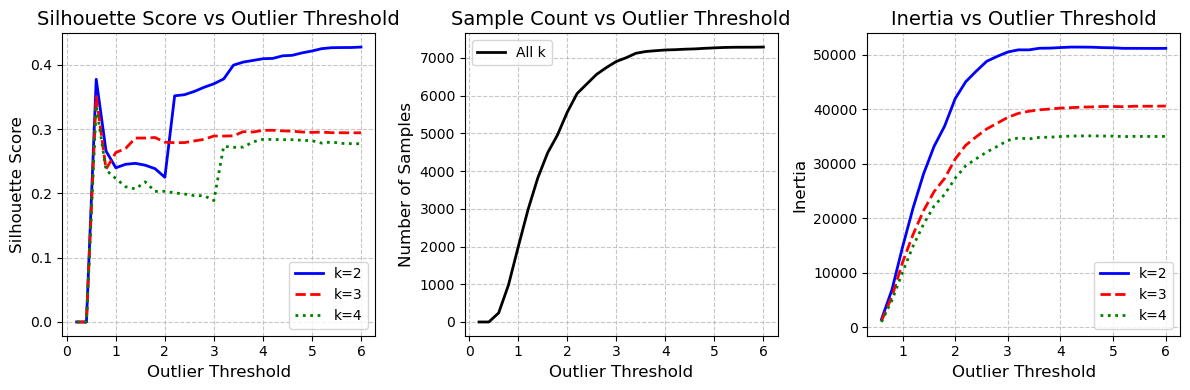


For k=2:
Best outlier threshold: 6.0 with silhouette score: 0.428
Number of samples with best threshold: 7287
Inertia with best threshold: 51154.98250475894

For k=3:
Best outlier threshold: 0.6000000000000001 with silhouette score: 0.351
Number of samples with best threshold: 239
Inertia with best threshold: 1166.8846839565695

For k=4:
Best outlier threshold: 0.6000000000000001 with silhouette score: 0.337
Number of samples with best threshold: 239
Inertia with best threshold: 969.2778209395998


In [29]:

# Only proceed with clustering if we have data
if len(df_for_clustering) > 0:
    # Create a copy of the data for scaling
    X = df_for_clustering[feature_cols].values
    depth_array = df_for_clustering['depth'].values

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply lower weights to PWVel, PWAmp, and MS
    # Get the indices of PWVel, PWAmp, MS, and standard deviation columns in the feature_cols list
    pwvel_idx = feature_cols.index('PWVel')
    pwamp_idx = feature_cols.index('PWAmp')
    ms_idx = feature_cols.index('MS')
    # ct_std_idx = feature_cols.index('CT_std')
    # r_std_idx = feature_cols.index('R_std')
    # g_std_idx = feature_cols.index('G_std')
    # b_std_idx = feature_cols.index('B_std')
    # lumin_std_idx = feature_cols.index('Lumin_std')
    
    # Apply weights to reduce influence of some low-resolution logs in the clustering analysis
    X_scaled[:, pwvel_idx] *= 0.05
    X_scaled[:, pwamp_idx] *= 0.05
    X_scaled[:, ms_idx] *= 0.25
    
    # # Apply lower weights to standard deviation columns
    # X_scaled[:, ct_std_idx] *= 0.05
    # X_scaled[:, r_std_idx] *= 0.05    
    # X_scaled[:, g_std_idx] *= 0.05
    # X_scaled[:, b_std_idx] *= 0.05
    # X_scaled[:, lumin_std_idx] *= 0.05
else:
    print("Warning: No complete data rows found for the selected features.")
    # Create an empty DataFrame with the necessary columns for downstream code
    df_for_clustering = pd.DataFrame(columns=feature_cols + ['depth', 'cluster_label', 'rock_type'])


# Test different outlier thresholds to find the optimal clustering result

outlier_thresholds = [i * 0.2 for i in range(1, 31)]
silhouette_scores = {k: [] for k in [2, 3, 4]}
inertia_values = {k: [] for k in [2, 3, 4]}
sample_counts = []
cluster_results = {k: [] for k in [2, 3, 4]}

for threshold in outlier_thresholds:
    # Select features and handle missing data
    df_temp = df_merged.dropna(subset=feature_cols).copy()
    
    # Calculate z-scores and filter outliers based on current threshold
    z_scores = stats.zscore(df_temp[feature_cols])
    abs_z_scores = np.abs(z_scores)
    outlier_mask = (abs_z_scores < threshold).all(axis=1)
    df_filtered = df_temp[outlier_mask]
    
    # Store the sample count (only need to do this once per threshold)
    sample_count = len(df_filtered)
    sample_counts.append(sample_count)
    
    # Test each k value
    for k in [2, 3, 4]:
        # Only proceed if we have enough data
        if sample_count > k:
            # Scale the data
            X = df_filtered[feature_cols].values
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            # Apply K-means
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_scaled)
            
            # Calculate silhouette score and inertia
            sil_score = silhouette_score(X_scaled, labels) if len(np.unique(labels)) > 1 else 0
            silhouette_scores[k].append(sil_score)
            inertia_values[k].append(kmeans.inertia_)
            
            # Store the clustering results for later visualization
            cluster_results[k].append({
                'threshold': threshold,
                'X_scaled': X_scaled,
                'labels': labels,
                'silhouette': sil_score,
                'sample_count': sample_count
            })
        else:
            silhouette_scores[k].append(0)
            inertia_values[k].append(float('inf'))

# Plot the evaluation metrics in a 1x3 grid
plt.figure(figsize=(12, 4))

# Line styles and colors for different k values
styles = {
    2: ('b-', 'k=2'),
    3: ('r--', 'k=3'),
    4: ('g:', 'k=4')
}

# Silhouette Score vs Outlier Threshold
plt.subplot(1, 3, 1)
for k in [2, 3, 4]:
    style, label = styles[k]
    plt.plot(outlier_thresholds, silhouette_scores[k], style, linewidth=2, label=label)
plt.xlabel('Outlier Threshold', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Outlier Threshold', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Sample Count vs Outlier Threshold
plt.subplot(1, 3, 2)
plt.plot(outlier_thresholds, sample_counts, 'k-', linewidth=2, label='All k')
plt.xlabel('Outlier Threshold', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Sample Count vs Outlier Threshold', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Inertia vs Outlier Threshold
plt.subplot(1, 3, 3)
for k in [2, 3, 4]:
    style, label = styles[k]
    valid_indices = [i for i, inertia in enumerate(inertia_values[k]) if inertia != float('inf')]
    valid_thresholds = [outlier_thresholds[i] for i in valid_indices]
    valid_inertias = [inertia_values[k][i] for i in valid_indices]
    
    if valid_inertias:
        plt.plot(valid_thresholds, valid_inertias, style, linewidth=2, label=label)

plt.xlabel('Outlier Threshold', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Inertia vs Outlier Threshold', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

# Print information about the best threshold for each k
for k in [2, 3, 4]:
    if silhouette_scores[k]:
        best_idx = np.argmax(silhouette_scores[k])
        best_threshold = outlier_thresholds[best_idx]
        print(f"\nFor k={k}:")
        print(f"Best outlier threshold: {best_threshold} with silhouette score: {silhouette_scores[k][best_idx]:.3f}")
        print(f"Number of samples with best threshold: {sample_counts[best_idx]}")
        print(f"Inertia with best threshold: {inertia_values[k][best_idx] if inertia_values[k][best_idx] != float('inf') else 'N/A'}")
    else:
        print(f"\nFor k={k}: No valid clustering results were obtained.")


/var/folders/nb/sjnrf0bd5rd3p_tlpft11hvc0000gn/T/ipykernel_31671/754413897.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8)


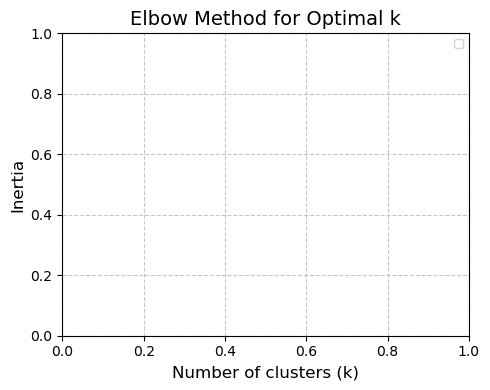

/var/folders/nb/sjnrf0bd5rd3p_tlpft11hvc0000gn/T/ipykernel_31671/754413897.py:99: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8)


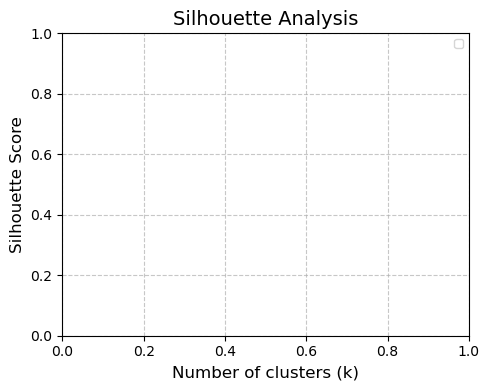

In [30]:
# Only proceed with clustering if we have data
if len(df_for_clustering) > 0:
    # Create a copy of the data for scaling
    X = df_for_clustering[feature_cols].values
    depth_array = df_for_clustering['depth'].values

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply lower weights to PWVel, PWAmp, and MS
    # Get the indices of PWVel, PWAmp, MS, and standard deviation columns in the feature_cols list
    pwvel_idx = feature_cols.index('PWVel')
    pwamp_idx = feature_cols.index('PWAmp')
    ms_idx = feature_cols.index('MS')
    # ct_std_idx = feature_cols.index('CT_std')
    # r_std_idx = feature_cols.index('R_std')
    # g_std_idx = feature_cols.index('G_std')
    # b_std_idx = feature_cols.index('B_std')
    # lumin_std_idx = feature_cols.index('Lumin_std')
    
    # Apply weights to reduce influence of some low-resolution logs in the clustering analysis
    X_scaled[:, pwvel_idx] *= 0.00
    X_scaled[:, pwamp_idx] *= 0.00
    X_scaled[:, ms_idx] *= 0.25
    
    # # Apply lower weights to standard deviation columns
    # X_scaled[:, ct_std_idx] *= 0.05
    # X_scaled[:, r_std_idx] *= 0.05    
    # X_scaled[:, g_std_idx] *= 0.05
    # X_scaled[:, b_std_idx] *= 0.05
    # X_scaled[:, lumin_std_idx] *= 0.05
else:
    print("Warning: No complete data rows found for the selected features.")
    # Create an empty DataFrame with the necessary columns for downstream code
    df_for_clustering = pd.DataFrame(columns=feature_cols + ['depth', 'cluster_label', 'rock_type'])


inertias = []
sil_scores = []
K_range = range(2, 11)
thresholds = [2, 3, 4, 5]
styles = ['g--', 'r:', 'm-.', 'b--']  # Different line styles for each threshold

# Create dictionaries to store results for each threshold
inertias_by_threshold = {t: [] for t in thresholds}
sil_scores_by_threshold = {t: [] for t in thresholds}

# Calculate metrics for each threshold and k
for threshold in thresholds:
    # Apply outlier filtering for this threshold
    z_scores = stats.zscore(X_scaled)
    abs_z_scores = np.abs(z_scores)
    outlier_mask = (abs_z_scores < threshold).all(axis=1)
    X_filtered = X_scaled[outlier_mask]
    
    if len(X_filtered) > 1:  # Ensure we have enough samples
        for k in K_range:
            kmeans_temp = KMeans(n_clusters=k, random_state=42)
            kmeans_temp.fit(X_filtered)
            
            # Store inertia
            inertias_by_threshold[threshold].append(kmeans_temp.inertia_)
            
            # Store silhouette score if we have enough samples
            if len(X_filtered) > k:
                labels_temp = kmeans_temp.labels_
                score = silhouette_score(X_filtered, labels_temp)
                sil_scores_by_threshold[threshold].append(score)
            else:
                sil_scores_by_threshold[threshold].append(np.nan)

# Plot elbow curves
plt.figure(figsize=(5,4))
for threshold, style in zip(thresholds, styles):
    if len(inertias_by_threshold[threshold]) > 0:
        plt.plot(K_range, inertias_by_threshold[threshold], style, 
                linewidth=2, label=f'Threshold={threshold}')

plt.xlabel("Number of clusters (k)", fontsize=12)
plt.ylabel("Inertia", fontsize=12)
plt.title("Elbow Method for Optimal k", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(5,4))
for threshold, style in zip(thresholds, styles):
    if len(sil_scores_by_threshold[threshold]) > 0:
        plt.plot(K_range, sil_scores_by_threshold[threshold], style,
                linewidth=2, label=f'Threshold={threshold}')

plt.xlabel("Number of clusters (k)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("Silhouette Analysis", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Find optimal k for each threshold
for threshold in thresholds:
    if len(inertias_by_threshold[threshold]) > 0:
        # Calculate the percentage change in inertia
        inertias = inertias_by_threshold[threshold]
        inertia_changes = np.diff(inertias) / np.array(inertias[:-1])
        
        # Find where the rate of change slows down significantly
        elbow_candidates = np.where(np.abs(np.diff(inertia_changes)) > np.std(inertia_changes))[0]
        if len(elbow_candidates) > 0:
            optimal_k = K_range[elbow_candidates[0] + 1]
        else:
            # Fallback method
            second_derivative = np.diff(np.diff(inertias))
            optimal_k = K_range[np.argmax(np.abs(second_derivative)) + 2]
            
        # Find best silhouette score
        sil_scores = sil_scores_by_threshold[threshold]
        best_sil_k = K_range[np.nanargmax(sil_scores)]
        
        print(f"\nFor threshold {threshold}:")
        print(f"Optimal k from elbow method: {optimal_k}")
        print(f"Best k from silhouette score: {best_sil_k}")

# 5) K-Means Clustering
Select numeric columns of interest, handle missing data, scale them, and run K-Means to find clusters.

Using optimal k=4 and best outlier threshold=6.0
Number of complete rows for clustering: 7349
Number of rows after outlier removal: 7287
Cluster means:
                       CT           R           G           B       Lumin  \
cluster_label                                                               
0              614.688263  154.303047  150.365326  114.551525  148.607381   
1              980.379741  106.661701  104.435738   76.678418  102.906046   
2              570.884380  136.629627  131.003424   98.426839  129.845538   
3              804.146300  131.966916  128.100016   97.209134  126.697833   

                Density         MS     hiresMS        PWVel      PWAmp  
cluster_label                                                           
0              1.288244  47.279089   73.766345  1072.823289  13.980034  
1              1.513280  79.367045  160.781515  1072.629227  12.306318  
2              1.250172  43.072037   56.065686  1072.577247  12.711476  
3              1.384

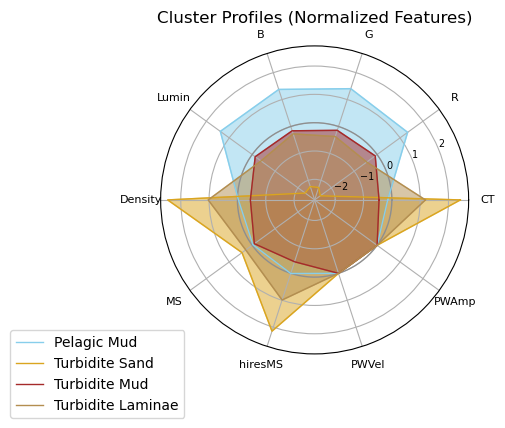

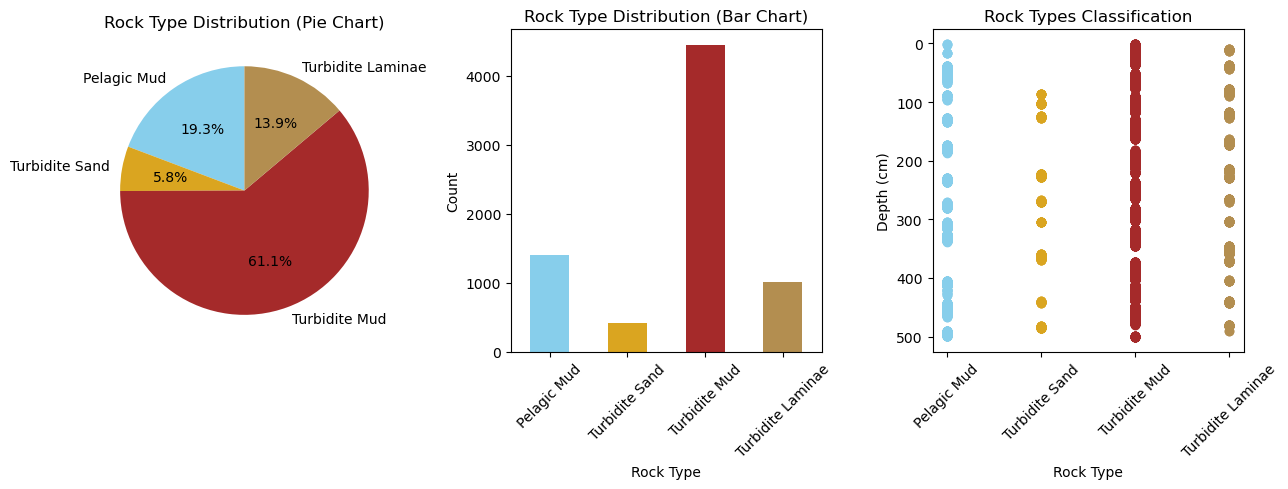

In [31]:
best_threshold = 6.0
k = 4

# Use the optimal k and best outlier threshold found from previous analysis
print(f"Using optimal k={k} and best outlier threshold={best_threshold}")

# Check if there are any rows with complete data for the selected features
df_for_clustering = df_merged.dropna(subset=feature_cols).copy()
print(f"Number of complete rows for clustering: {len(df_for_clustering)}")

# Apply outlier filtering using the newly defined best threshold
z_scores = stats.zscore(df_for_clustering[feature_cols])
abs_z_scores = np.abs(z_scores)
outlier_mask = (abs_z_scores < best_threshold).all(axis=1)
df_for_clustering = df_for_clustering[outlier_mask]

print(f"Number of rows after outlier removal: {len(df_for_clustering)}")

# Only proceed with clustering if we have data
if len(df_for_clustering) > 0:
    # Create a copy of the data for scaling
    X = df_for_clustering[feature_cols].values
    depth_array = df_for_clustering['depth'].values

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply lower weights to PWVel, PWAmp, and MS
    # Get the indices of PWVel, PWAmp, MS, and standard deviation columns in the feature_cols list
    pwvel_idx = feature_cols.index('PWVel')
    pwamp_idx = feature_cols.index('PWAmp')
    ms_idx = feature_cols.index('MS')
    # ct_std_idx = feature_cols.index('CT_std')
    # r_std_idx = feature_cols.index('R_std')
    # g_std_idx = feature_cols.index('G_std')
    # b_std_idx = feature_cols.index('B_std')
    # lumin_std_idx = feature_cols.index('Lumin_std')
    
    # Apply weights to reduce influence of some low-resolution logs in the clustering analysis
    X_scaled[:, pwvel_idx] *= 0.00
    X_scaled[:, pwamp_idx] *= 0.00
    X_scaled[:, ms_idx] *= 0.25
    
    # # Apply lower weights to standard deviation columns
    # X_scaled[:, ct_std_idx] *= 0.05
    # X_scaled[:, r_std_idx] *= 0.05    
    # X_scaled[:, g_std_idx] *= 0.05
    # X_scaled[:, b_std_idx] *= 0.05
    # X_scaled[:, lumin_std_idx] *= 0.05

    # Use the optimal k from previous analysis
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)

    labels = kmeans.labels_
    df_for_clustering['cluster_label'] = labels
    
    # Calculate cluster means to determine cluster characteristics
    cluster_means = df_for_clustering.groupby('cluster_label')[feature_cols].mean()
    print("Cluster means:")
    print(cluster_means)
    
    # Determine cluster names based on characteristics
    # Initialize dictionaries for cluster names and colors
    cluster_names = {}
    cluster_colors = {}
    
    # Find the cluster with high hiresMS, density, MS, CT and low RGB/Lumin (Turbidite Sand)
    sand_indicators = ['hiresMS', 'Density', 'MS', 'CT']
    sand_scores = cluster_means[sand_indicators].mean(axis=1)
    
    # Find the cluster with high RGB and Lumin (Pelagic Mud)
    pelagic_indicators = ['R', 'G', 'B', 'Lumin']
    pelagic_scores = cluster_means[pelagic_indicators].mean(axis=1)
    
    # Assign cluster names based on characteristics
    turbidite_sand_cluster = sand_scores.idxmax()
    pelagic_mud_cluster = pelagic_scores.idxmax()
    
    # The remaining cluster is Turbidite Mud
    all_clusters = set(range(k))
    assigned_clusters = {turbidite_sand_cluster, pelagic_mud_cluster}
    remaining_clusters = all_clusters - assigned_clusters
    
    # If we have a conflict (same cluster identified for two types), resolve it
    if len(remaining_clusters) < 1:
        # Re-evaluate using more specific criteria
        # For turbidite sand: high density and CT are most important
        sand_specific = cluster_means[['Density', 'CT']].mean(axis=1)
        turbidite_sand_cluster = sand_specific.idxmax()
        
        # For pelagic mud: high RGB values are most important
        pelagic_specific = cluster_means[['R', 'G', 'B']].mean(axis=1)
        pelagic_mud_cluster = pelagic_specific.idxmax()
        
        # Recalculate remaining clusters
        assigned_clusters = {turbidite_sand_cluster, pelagic_mud_cluster}
        remaining_clusters = all_clusters - assigned_clusters
    
    # Assign names and colors based on number of clusters
    if k == 2:
        # For k=2, assign Turbidite Sand to cluster with low RGB/Lum and high MS/Density
        rgb_lum_scores = cluster_means[['R', 'G', 'B', 'Lumin']].mean(axis=1)
        ms_density_scores = cluster_means[['MS', 'hiresMS', 'Density']].mean(axis=1)
        
        # Normalize scores
        rgb_lum_norm = (rgb_lum_scores - rgb_lum_scores.min()) / (rgb_lum_scores.max() - rgb_lum_scores.min())
        ms_density_norm = (ms_density_scores - ms_density_scores.min()) / (ms_density_scores.max() - ms_density_scores.min())
        
        # Calculate combined score (low RGB/Lum and high MS/Density)
        combined_score = ms_density_norm - rgb_lum_norm
        turbidite_sand_cluster = combined_score.idxmax()
        
        # Assign names and colors
        cluster_names[turbidite_sand_cluster] = 'Turbidite Sand'
        cluster_colors[turbidite_sand_cluster] = 'goldenrod'
        
        # Other cluster is Mud
        mud_cluster = 1 if turbidite_sand_cluster == 0 else 0
        cluster_names[mud_cluster] = 'Mud'
        cluster_colors[mud_cluster] = 'brown'
        
    else:
        # For k>=3, first three clusters follow original naming
        cluster_names[turbidite_sand_cluster] = 'Turbidite Sand'
        cluster_colors[turbidite_sand_cluster] = 'goldenrod'
        
        cluster_names[pelagic_mud_cluster] = 'Pelagic Mud'
        cluster_colors[pelagic_mud_cluster] = 'skyblue'
        
        # Assign the remaining cluster as Turbidite Mud
        if remaining_clusters:
            turbidite_mud_cluster = list(remaining_clusters)[0]
            cluster_names[turbidite_mud_cluster] = 'Turbidite Mud'
            cluster_colors[turbidite_mud_cluster] = 'brown'
        
        # For k=4, use a color between brown and skyblue
        if k == 4:
            for i in list(all_clusters):
                if i not in cluster_names:
                    cluster_names[i] = f'Turbidite Laminae'
                    # Mix of brown and skyblue
                    cluster_colors[i] = '#B38E50'  # A color between goldenrod and brown
        
        # For k>4, additional clusters get numbered names and random colors
        elif k > 4:
            for i in list(all_clusters):
                if i not in cluster_names:
                    cluster_names[i] = f'Cluster {i}'
                    r = random.random()
                    g = random.random()
                    b = random.random()
                    cluster_colors[i] = (r, g, b)
    
    # Add cluster names to the dataframe
    df_for_clustering['rock_type'] = df_for_clustering['cluster_label'].map(cluster_names)

    print("Cluster distribution:")
    for cluster_id, name in cluster_names.items():
        count = (df_for_clustering['cluster_label'] == cluster_id).sum()
        print(f"{cluster_id} - {name}: {count}")
    
    # Visualize cluster characteristics with a radar chart
    plt.figure(figsize=(5, 4))
    cluster_centers = kmeans.cluster_centers_
    
    # Get feature names for the radar chart
    feature_names = feature_cols
    
    # Number of variables
    N = len(feature_names)
    
    # Create angles for each feature
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create the plot
    ax = plt.subplot(111, polar=True)
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], feature_names, size=8)
    
    # Set ytick labels to x-small font size
    plt.yticks(size='x-small')
    
    # Add a darker line for 0.0
    ax.plot(np.linspace(0, 2*np.pi, 100), [0]*100, color='gray', linewidth=1.0, linestyle='-', alpha=0.7)
    
    # Draw the cluster profiles
    for i in range(k):
        values = cluster_centers[i].tolist()
        values += values[:1]  # Close the loop
        if i in cluster_names and i in cluster_colors:
            ax.plot(angles, values, linewidth=1.0, linestyle='solid', label=cluster_names[i], color=cluster_colors[i])
            ax.fill(angles, values, alpha=0.5, color=cluster_colors[i])
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Cluster Profiles (Normalized Features)")
    plt.show()
    
    # Visualize cluster distribution
    plt.figure(figsize=(13, 5))
    
    # Plot 1: Pie chart of cluster distribution
    plt.subplot(1, 3, 1)
    cluster_counts = df_for_clustering['cluster_label'].value_counts().sort_index()
    # Fix: Make sure all cluster indices are in the cluster_colors dictionary
    colors = [cluster_colors.get(i, (0.5, 0.5, 0.5)) for i in cluster_counts.index]
    plt.pie(cluster_counts, labels=[cluster_names.get(i, f'Cluster {i}') for i in cluster_counts.index], 
            autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Rock Type Distribution (Pie Chart)')
    
    # Plot 2: Bar chart of cluster distribution
    plt.subplot(1, 3, 2)
    cluster_counts.plot(kind='bar', color=colors)
    plt.title('Rock Type Distribution (Bar Chart)')
    plt.xlabel('Rock Type')
    plt.ylabel('Count')
    plt.xticks(range(len(cluster_counts)), [cluster_names.get(i, f'Cluster {i}') for i in cluster_counts.index], rotation=45)
    
    # Plot 3: Depth vs Cluster visualization
    plt.subplot(1, 3, 3)
    
    # Create a scatter plot with consistent colors
    for cluster_id in df_for_clustering['cluster_label'].unique():
        cluster_data = df_for_clustering[df_for_clustering['cluster_label'] == cluster_id]
        plt.scatter([cluster_id] * len(cluster_data), cluster_data['depth'],
                   color=cluster_colors.get(cluster_id, (0.5, 0.5, 0.5)), 
                   label=cluster_names.get(cluster_id, f'Cluster {cluster_id}'))
    
    plt.gca().invert_yaxis()
    plt.title(f"Rock Types Classification")
    plt.xlabel("Rock Type")
    plt.ylabel("Depth (cm)")
    
    # Add a custom color bar with meaningful labels
    plt.xticks(sorted(df_for_clustering['cluster_label'].unique()), 
              [cluster_names.get(i, f'Cluster {i}') for i in sorted(df_for_clustering['cluster_label'].unique())], 
              rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("Warning: No complete data rows found for the selected features.")
    # Create an empty DataFrame with the necessary columns for downstream code
    df_for_clustering = pd.DataFrame(columns=feature_cols + ['depth', 'cluster_label', 'rock_type'])

# Cluster Visualization
Plot cluster labels versus depth with a simple scatter. Depth on the y-axis, cluster label on the x-axis, color-coded by label.

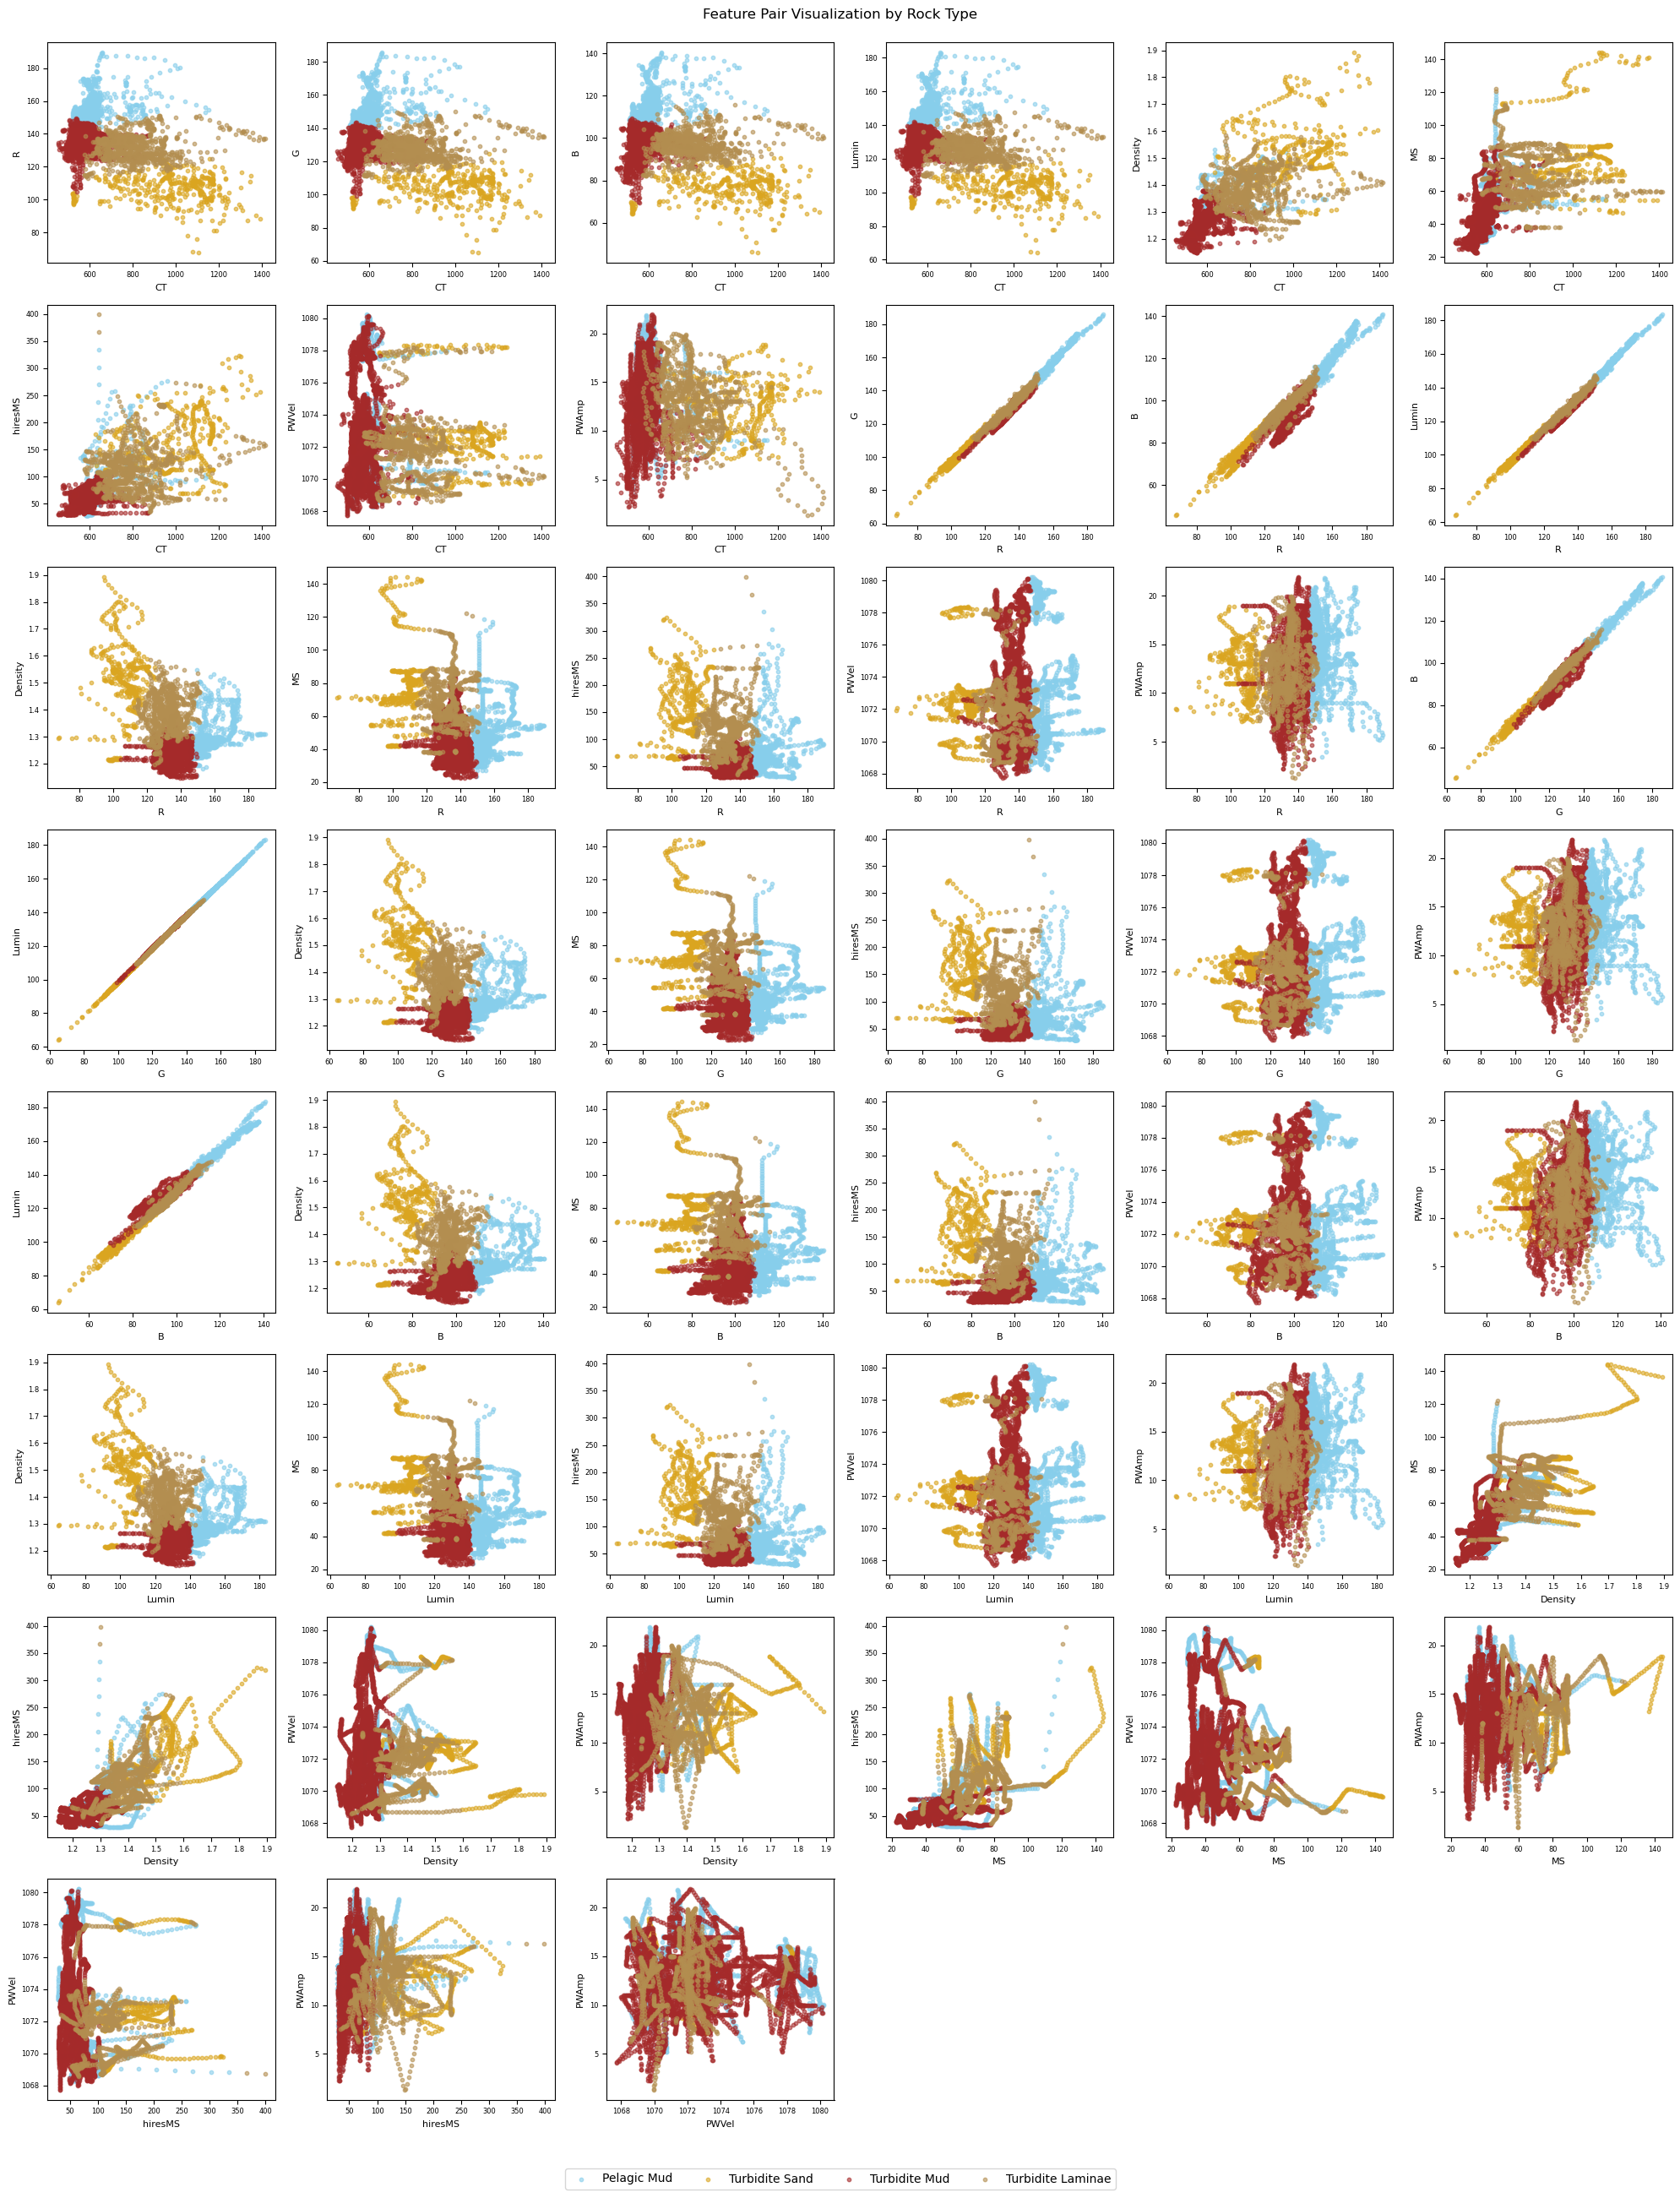

In [32]:
# Create individual feature plots to visualize cluster separation
if len(df_for_clustering) > 0:
    # Use all features for visualization
    vis_features = feature_cols
    
    # Calculate number of feature pairs
    n_features = len(vis_features)
    n_pairs = n_features * (n_features - 1) // 2  # Number of unique pairs
    
    # Calculate number of rows and columns for subplots
    n_cols = 6 # You can adjust this for layout
    n_rows = (n_pairs + n_cols - 1) // n_cols
    
    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 25))
    
    # Flatten axes array for easier indexing
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    # Plot each feature pair
    plot_idx = 0
    for i in range(n_features):
        for j in range(i+1, n_features):
            if plot_idx < len(axes):
                ax = axes[plot_idx]
                
                # Get feature names for this pair
                feat_x = vis_features[i]
                feat_y = vis_features[j]
                
                # Scatter plot of feature pair
                for cluster_id in range(k):
                    cluster_points = df_for_clustering[df_for_clustering['cluster_label'] == cluster_id]
                    ax.scatter(cluster_points[feat_x], cluster_points[feat_y], 
                              s=10, alpha=0.6, color=cluster_colors[cluster_id], 
                              label=cluster_names[cluster_id])
                
                # Set labels
                ax.set_xlabel(feat_x, fontsize=8)
                ax.set_ylabel(feat_y, fontsize=8)
                ax.tick_params(axis='both', which='major', labelsize=6)
                
                plot_idx += 1
    
    # Hide any unused subplots
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    # Add a single legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    # Place legend outside the figure at the bottom
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=k)
    
    # Adjust figure margins to make room for the legend
    plt.subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.suptitle("Feature Pair Visualization by Rock Type", y=1.01)
    plt.show()

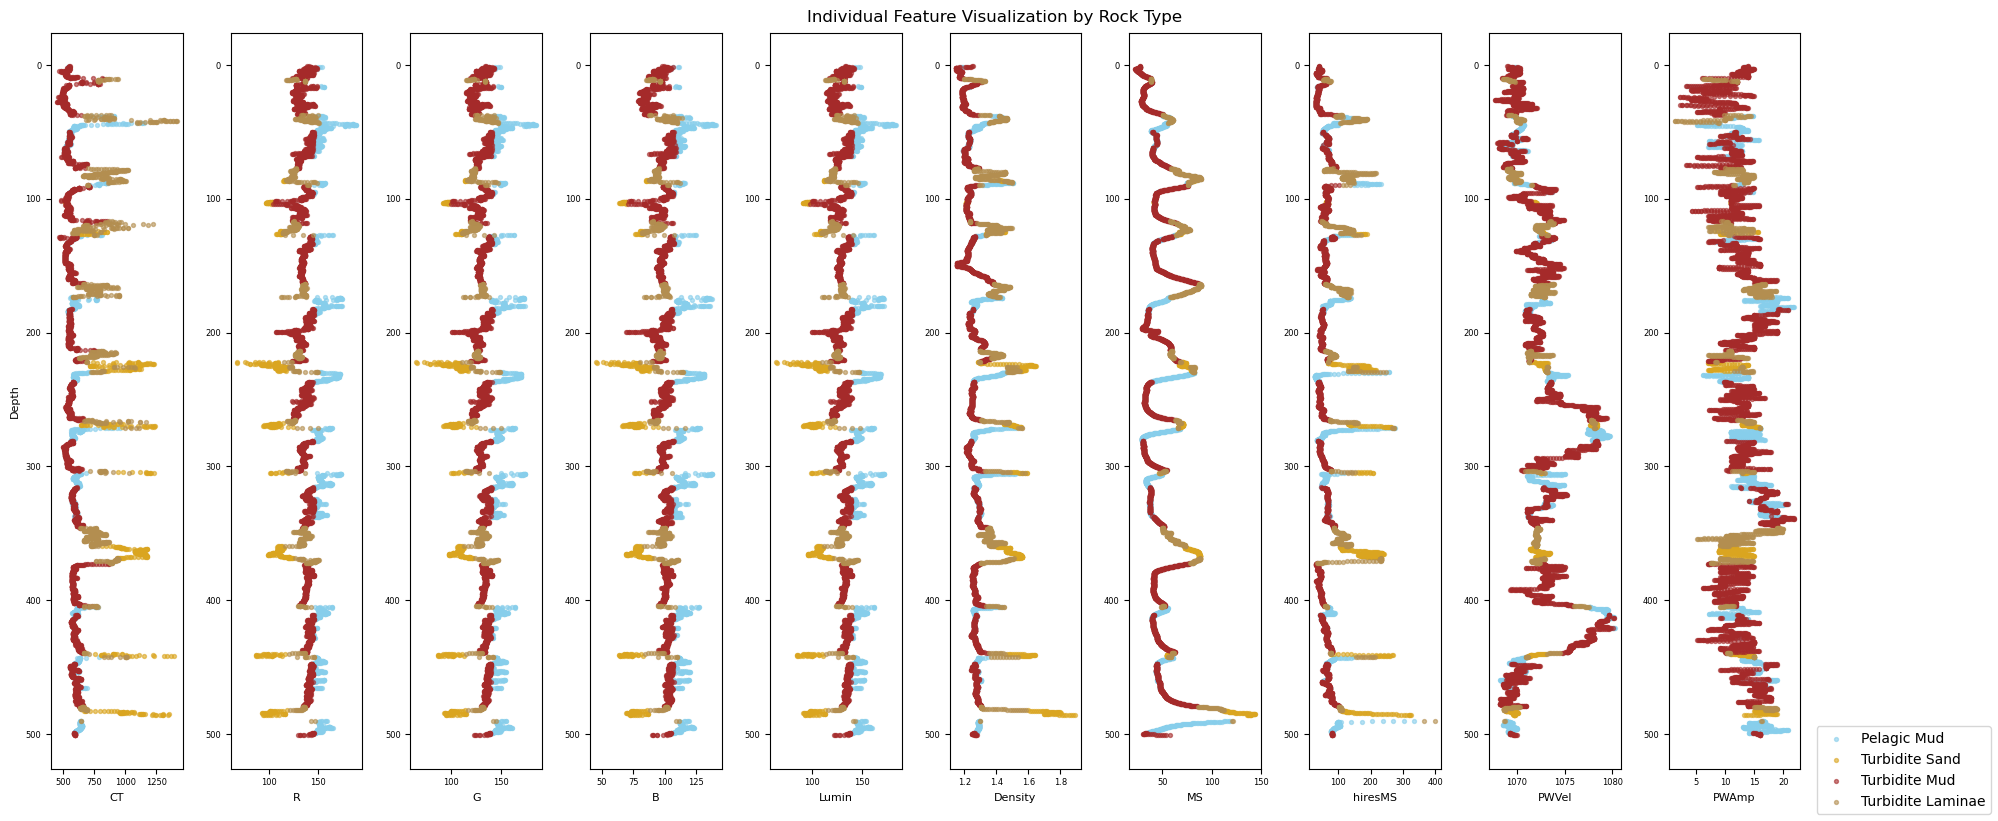

In [33]:
# 3. Create individual feature plots to visualize cluster separation
if len(df_for_clustering) > 0:
    # Use all features for visualization
    vis_features = feature_cols
    
    # Calculate number of rows and columns for subplots
    n_features = len(vis_features)
    n_cols = 11  # You can adjust this for layout
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
    
    # Flatten axes array for easier indexing
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    # Plot each feature
    for i, feat in enumerate(vis_features):
        if i < len(axes):
            ax = axes[i]
            
            # Scatter plot of feature vs depth
            for cluster_id in range(k):
                cluster_points = df_for_clustering[df_for_clustering['cluster_label'] == cluster_id]
                ax.scatter(cluster_points[feat], cluster_points['depth'], 
                          s=8, alpha=0.6, color=cluster_colors[cluster_id], 
                          label=cluster_names[cluster_id])
            
            # Set labels
            ax.set_xlabel(feat, fontsize=8)
            # Only show y-axis label for the first column
            if i % n_cols == 0:
                ax.set_ylabel('Depth', fontsize=8)
            else:
                ax.set_ylabel('', fontsize=8)
            ax.tick_params(axis='both', which='major', labelsize=6)
            ax.invert_yaxis()  # Invert y-axis for depth
    
    # Hide any unused subplots
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    # Add a single legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right', ncol=1)
    
    plt.tight_layout()
    plt.suptitle("Individual Feature Visualization by Rock Type", y=1.01)
    plt.show()


# Colored Lithology-Style Column
Generate a vertically oriented color column indicating cluster assignments at each depth interval.

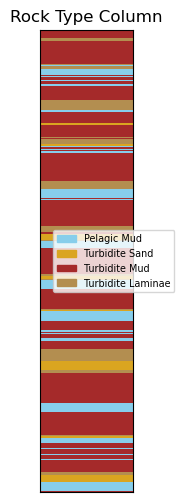

In [34]:
df_for_clustering_sorted = df_for_clustering.sort_values(by='depth').reset_index(drop=True)
depth_vals = df_for_clustering_sorted['depth'].values
labels_vals = df_for_clustering_sorted['cluster_label'].values

fig, ax = plt.subplots(figsize=(1.2,6))

# Use the same cluster colors defined earlier
colors = [cluster_colors[i] for i in range(k)]

for i in range(len(depth_vals)-1):
    top = depth_vals[i]
    bottom = depth_vals[i+1]
    c_label = labels_vals[i]
    color = cluster_colors[c_label]
    ax.add_patch(
        mpatches.Rectangle((0, top), 1, bottom - top,
                           facecolor=color, edgecolor='none')
    )

# Add a legend showing rock types
handles = [mpatches.Patch(color=cluster_colors[i], label=cluster_names[i]) for i in range(k)]
ax.legend(handles=handles, loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize='x-small')

ax.set_ylim([depth_vals.max(), depth_vals.min()])
ax.set_xlim([0, 1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Rock Type Column")
plt.show()

In [35]:
def plot_core_logs(data_paths, column_configs, core_length, ct_img=None, rgb_img=None, title='Combined Logs', cluster_data=None):
    """
    Plot core logs from multiple data sources.
    
    Args:
        data_paths (dict): Dictionary containing paths to data files
            e.g. {a
                'ct': 'path/to/ct.csv',
                'rgb': 'path/to/rgb.csv', 
                'mst': 'path/to/mst.csv',
                'hrms': 'path/to/hrms.csv'
            }
        column_configs (dict): Configuration for columns to plot
            e.g. {
                'ct': {'data_col': 'CT', 'std_col': 'CT_std', 'depth_col': 'SB_DEPTH_cm'},
                'rgb': {'data_cols': ['R','G','B'], 'std_cols': ['R_std','G_std','B_std'], 'depth_col': 'SB_DEPTH_cm'},
                'mst': {
                    'density': {'data_col': 'Den_gm/cc', 'depth_col': 'SB_DEPTH_cm'},
                    'pwvel': {'data_col': 'PWVel_m/s', 'depth_col': 'SB_DEPTH_cm'},
                    'pwamp': {'data_col': 'PWAmp', 'depth_col': 'SB_DEPTH_cm'},
                    'elecres': {'data_col': 'ElecRes_ohmm', 'depth_col': 'SB_DEPTH_cm'},
                    'ms': {'data_col': 'MS', 'depth_col': 'SB_DEPTH_cm'}
                },
                'hrms': {'data_col': 'hiresMS', 'depth_col': 'SB_DEPTH_cm'}
            }
        core_length (float): Length of the core in cm
        ct_img (array, optional): CT image array
        rgb_img (array, optional): RGB image array
        title (str): Title for the plot
        cluster_data (dict, optional): Dictionary containing cluster data
            e.g. {
                'depth_vals': depth_values_array,
                'labels_vals': cluster_labels_array,
                'k': number_of_clusters
            }
    """
    # Load data
    data = {}
    for key, path in data_paths.items():
        if path:
            data[key] = pd.read_csv(path)
            if 'SB_DEPTH_cm' not in data[key].columns:
                raise ValueError(f"SB_DEPTH_cm column missing in {key} data")
    
    # Calculate number of plots needed
    n_plots = 0  # Start with 0
    
    # Add cluster column if cluster data exists
    if cluster_data is not None:
        n_plots += 1
    
    # Add CT panels if CT image and data exist
    if ct_img is not None and 'ct' in data:
        n_plots += 2  # CT image and data
        
    # Add RGB panels if RGB image and data exist  
    if rgb_img is not None and 'rgb' in data:
        n_plots += 2  # RGB image and data
        
    # Add MS panel if either MST MS data or hiresMS data exists and has data
    if ('mst' in data and column_configs['mst']['ms']['data_col'] in data['mst'].columns and not data['mst'][column_configs['mst']['ms']['data_col']].isna().all()) or ('hrms' in data and not data['hrms'][column_configs['hrms']['data_col']].isna().all()):
        n_plots += 1
        
    # Add panels for other MST logs that exist and have data
    if 'mst' in data:
        for log_type, config in column_configs['mst'].items():
            if log_type != 'ms':  # Skip MS since it's handled separately
                if config['data_col'] in data['mst'].columns and not data['mst'][config['data_col']].isna().all():
                    n_plots += 1

    if n_plots == 0:
        raise ValueError("No valid data to plot")
    
    # Create figure and axes
    fig, axes = plt.subplots(1, n_plots, figsize=(10, 16), sharey=True)
    if n_plots == 1:
        axes = [axes]  # Ensure axes is iterable
    fig.suptitle(title, fontweight='bold')
    
    current_ax = 0
    
    # ---------------------------
    # Plot Cluster Column if available
    # ---------------------------
    if cluster_data is not None:
        depth_vals = cluster_data['depth_vals']
        labels_vals = cluster_data['labels_vals']
        k = cluster_data['k']
        
        # Use the same cluster colors defined earlier
        colors = [cluster_colors[i] for i in range(k)]
        
        for i in range(len(depth_vals)-1):
            top = depth_vals[i]
            bottom = depth_vals[i+1]
            c_label = labels_vals[i]
            color = cluster_colors[c_label]
            axes[current_ax].add_patch(
                mpatches.Rectangle((0, top), 1, bottom - top,
                                  facecolor=color, edgecolor='none')
            )
        
        # Add a legend showing rock types
        handles = [mpatches.Patch(color=cluster_colors[i], label=cluster_names[i]) for i in range(k)]
        axes[current_ax].legend(handles=handles, loc='center right', fontsize='x-small')
        
        axes[current_ax].set_ylim([depth_vals.max(), depth_vals.min()])
        axes[current_ax].set_xlim([0, 1])
        axes[current_ax].set_xticks([])
        axes[current_ax].set_xlabel('Rock Type\nColumn', fontweight='bold', fontsize='small')
        current_ax += 1
    
    # ---------------------------
    # Plot CT image and data
    # ---------------------------
    if ct_img is not None and 'ct' in data:
        # Plot CT image
        axes[current_ax].imshow(ct_img, aspect='auto', extent=[0, 0.5, core_length, 0])
        axes[current_ax].set_ylabel('Depth (cm)')
        axes[current_ax].set_xticks([])
        axes[current_ax].set_xlabel('Sediment\nCore\nCT Scan', fontweight='bold', fontsize='small')
        current_ax += 1
        
        # Plot CT data
        ct_col = column_configs['ct']['data_col']
        ct_std = column_configs['ct']['std_col']
        ct_depth = data['ct'][column_configs['ct']['depth_col']].astype(np.float64)
        
        axes[current_ax].plot(data['ct'][ct_col].astype(np.float64), ct_depth, 
                              color='black', linewidth=0.7)
        
        # Standard deviation fill
        axes[current_ax].fill_betweenx(
            ct_depth,
            data['ct'][ct_col].astype(np.float64) - data['ct'][ct_std].astype(np.float64),
            data['ct'][ct_col].astype(np.float64) + data['ct'][ct_std].astype(np.float64),
            color='black', alpha=0.2, linewidth=0
        )
        
        # Color-coded CT values using PolyCollection
        ct_values = data['ct'][ct_col].astype(np.float64).values
        depths = ct_depth.values
        norm = plt.Normalize(300, 1600)
        cmap = plt.cm.jet
        
        ct_polys = []
        ct_facecolors = []
        for i in range(len(depths) - 1):
            # Ignore segments with NaN values
            if not (np.isnan(ct_values[i]) or np.isnan(ct_values[i+1])):
                poly = [
                    (0, depths[i]),
                    (ct_values[i], depths[i]),
                    (ct_values[i+1], depths[i+1]),
                    (0, depths[i+1])
                ]
                ct_polys.append(poly)
                # Use the average value for smoother color transition
                avg_val = (ct_values[i] + ct_values[i+1]) / 2
                ct_facecolors.append(cmap(norm(avg_val)))
                
        if ct_polys:
            import matplotlib.collections as mcoll
            pc_ct = mcoll.PolyCollection(ct_polys, facecolors=ct_facecolors, edgecolors='none', alpha=0.95)
            axes[current_ax].add_collection(pc_ct)
        
        axes[current_ax].set_xlabel('CT#\nBrightness', fontweight='bold', fontsize='small')
        axes[current_ax].grid(True)
        axes[current_ax].set_xlim(300, None)
        axes[current_ax].tick_params(axis='x', labelsize='x-small')
        current_ax += 1
    
    # ---------------------------
    # Plot RGB image and data
    # ---------------------------
    if rgb_img is not None and 'rgb' in data:
        # Plot RGB image
        axes[current_ax].imshow(rgb_img, aspect='auto', extent=[0, 0.5, core_length, 0])
        axes[current_ax].set_xticks([])
        axes[current_ax].set_xlabel('Sediment\nCore\nPhoto', fontweight='bold', fontsize='small')
        current_ax += 1
        
        # Plot RGB data (R, G, B channels)
        rgb_cols = column_configs['rgb']['data_cols']
        rgb_stds = column_configs['rgb']['std_cols']
        rgb_depth = data['rgb'][column_configs['rgb']['depth_col']].astype(np.float64)
        colors = ['red', 'green', 'blue']
        
        for col, std, color in zip(rgb_cols[:3], rgb_stds[:3], colors):
            axes[current_ax].plot(data['rgb'][col].astype(np.float64), rgb_depth,
                                  color=color, linewidth=0.7)
            axes[current_ax].fill_betweenx(
                rgb_depth,
                data['rgb'][col].astype(np.float64) - data['rgb'][std].astype(np.float64),
                data['rgb'][col].astype(np.float64) + data['rgb'][std].astype(np.float64),
                color=color, alpha=0.2, linewidth=0
            )
        
        # Luminance plot using PolyCollection with Inferno colormap
        lumin_values = data['rgb']['Lumin'].astype(np.float64).values
        lumin_depths = rgb_depth.values
        
        # Compute normalization range ignoring NaNs
        valid_lumin = lumin_values[~np.isnan(lumin_values)]
        if len(valid_lumin) == 0:
            vmin, vmax = 0, 1
        else:
            vmin, vmax = valid_lumin.min(), valid_lumin.max()
            if np.isclose(vmin, vmax):
                vmin, vmax = 0, 1
        
        lumin_norm = plt.Normalize(vmin, vmax)
        cmap_inferno = plt.cm.inferno
        
        lumin_polys = []
        lumin_facecolors = []
        for i in range(len(lumin_depths) - 1):
            # Only use segments with valid (non-NaN) endpoints
            if not (np.isnan(lumin_values[i]) or np.isnan(lumin_values[i+1])):
                poly = [
                    (0, lumin_depths[i]),
                    (lumin_values[i], lumin_depths[i]),
                    (lumin_values[i+1], lumin_depths[i+1]),
                    (0, lumin_depths[i+1])
                ]
                lumin_polys.append(poly)
                # Use average value for color mapping
                avg_val = (lumin_values[i] + lumin_values[i+1]) / 2
                lumin_facecolors.append(cmap_inferno(lumin_norm(avg_val)))
        if lumin_polys:
            import matplotlib.collections as mcoll
            pc_lumin = mcoll.PolyCollection(lumin_polys, facecolors=lumin_facecolors, edgecolors='none', alpha=0.95)
            axes[current_ax].add_collection(pc_lumin)
        
        axes[current_ax].set_xlabel('RGB\nLuminance', fontweight='bold', fontsize='small')
        axes[current_ax].grid(True)
        axes[current_ax].tick_params(axis='x', labelsize='x-small')
        current_ax += 1
    
    # ---------------------------
    # Plot MS and MST data if available
    # ---------------------------
    if 'mst' in data:
        # Plot MS data if available
        ms_col = column_configs['mst']['ms']['data_col']
        has_mst_ms = 'mst' in data and ms_col in data['mst'].columns and not data['mst'][ms_col].isna().all()
        has_hrms = 'hrms' in data and not data['hrms'][column_configs['hrms']['data_col']].isna().all()

        if has_mst_ms or has_hrms:
            if has_mst_ms:
                axes[current_ax].plot(
                    data['mst'][ms_col].astype(np.float64), 
                    data['mst'][column_configs['mst']['ms']['depth_col']].astype(np.float64),
                    color='darkgray', label='Lo-res', linewidth=0.7
                )
            if has_hrms:
                axes[current_ax].plot(
                    data['hrms'][column_configs['hrms']['data_col']].astype(np.float64), 
                    data['hrms'][column_configs['hrms']['depth_col']].astype(np.float64),
                    color='black', label='Hi-res', linewidth=0.7
                )
            axes[current_ax].tick_params(axis='x', labelsize='x-small')
            axes[current_ax].set_xlabel('Magnetic\nSusceptibility', fontweight='bold')
            axes[current_ax].grid(True)
            current_ax += 1

        # Plot remaining MST logs that have data
        mst_labels = {
            'density': 'Density\n(g/cc)',
            'pwvel': 'P-wave\nVelocity\n(m/s)',
            'pwamp': 'P-wave\nAmplitude',
            'elecres': 'Electrical\nResistivity\n(ohm-m)'
        }
        
        mst_colors = {
            'density': 'orange',
            'pwvel': 'purple',
            'pwamp': 'purple',
            'elecres': 'brown'
        }

        for log_type, config in column_configs['mst'].items():
            if log_type != 'ms' and config['data_col'] in data['mst'].columns and not data['mst'][config['data_col']].isna().all():
                axes[current_ax].plot(
                    data['mst'][config['data_col']].astype(np.float64), 
                    data['mst'][config['depth_col']].astype(np.float64), 
                    color=mst_colors.get(log_type, 'black'), 
                    linewidth=0.7
                )
                axes[current_ax].set_xlabel(mst_labels[log_type], fontweight='bold', fontsize='small')
                axes[current_ax].tick_params(axis='x', labelsize='x-small')
                axes[current_ax].grid(True)
                if log_type == 'density':
                    axes[current_ax].set_xlim(1, 2)
                current_ax += 1
    
    # ---------------------------
    # Set common y-axis properties
    # ---------------------------
    for ax in axes:
        ax.invert_yaxis()
        ax.set_ylim(core_length, 0)
    
    plt.tight_layout()
    return fig, axes

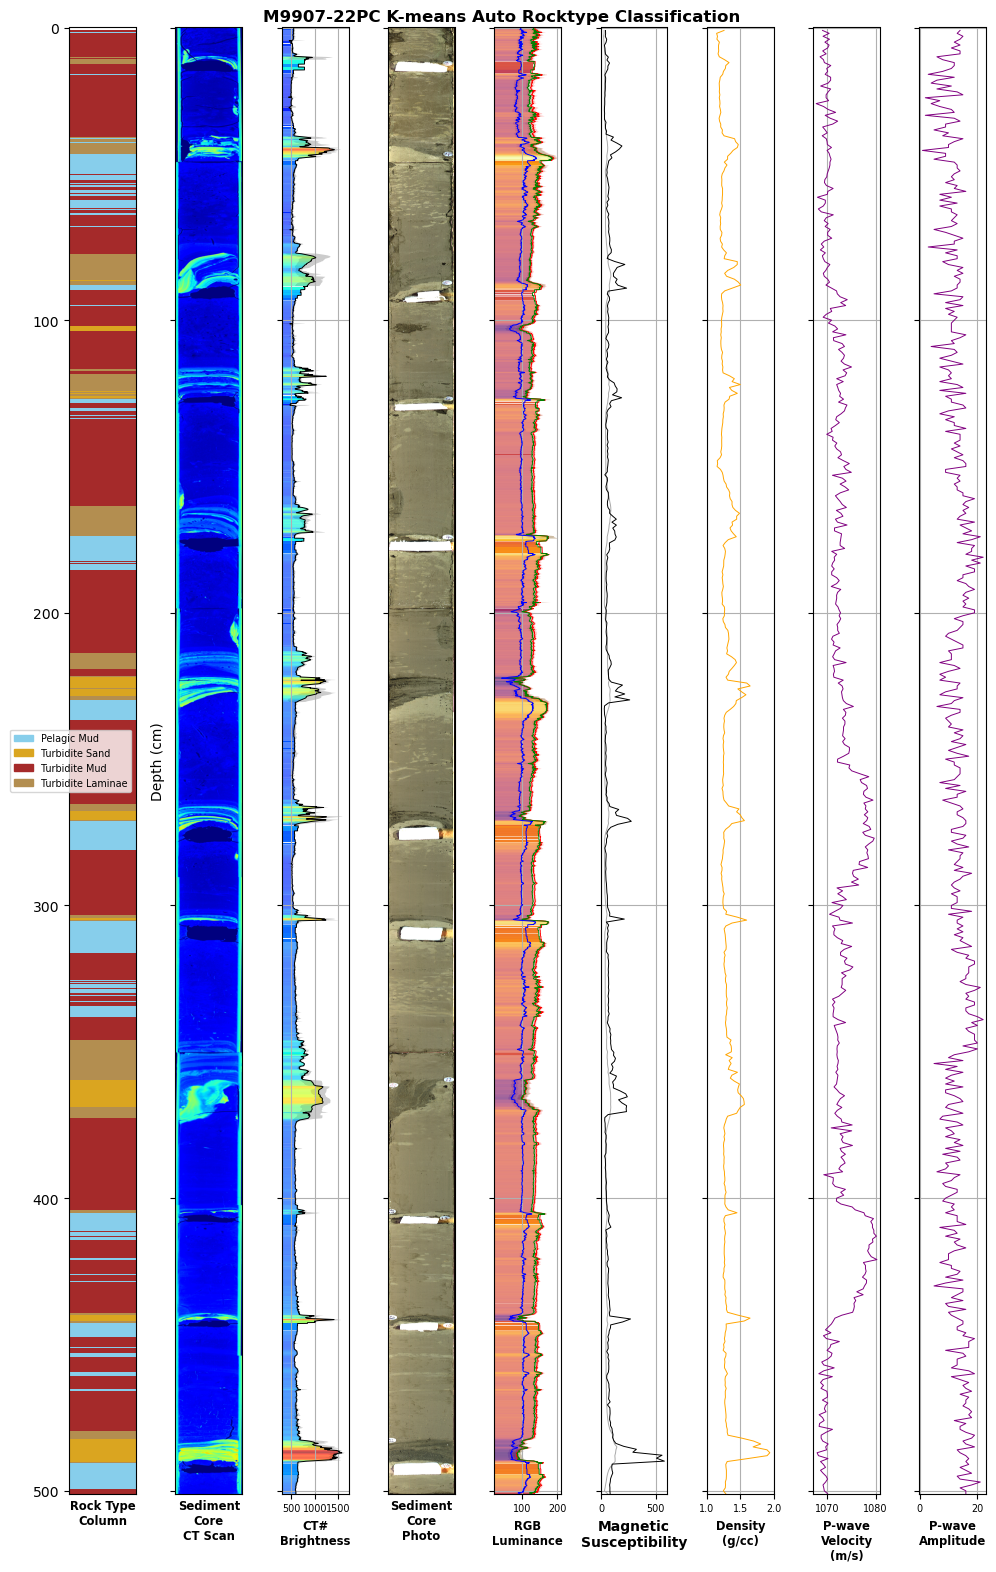

In [36]:
# Plot processed/cleaned logs
plt_title = f'{core_name} K-means Auto Rocktype Classification'

# Create cluster data dictionary for the plot_core_logs function
cluster_data = {
    'depth_vals': df_for_clustering_sorted['depth'].values,
    'labels_vals': df_for_clustering_sorted['cluster_label'].values,
    'k': k
}

fig, axes = plot_core_logs(filled_data_paths, column_configs, core_length, ct_img, rgb_img, 
                          title=plt_title, cluster_data=cluster_data)
plt.show()

<hr>

# Using GaussianMixture Instead of K-Means

You can try the Gaussian Mixture Model (GMM) from sklearn.mixture, which may be more flexible if your data is not spherical in feature space. A typical approach is to evaluate BIC or AIC for different numbers of components:

In [37]:
# Merge the resampled dataframes
df_merged = df_ct_resampled.merge(df_rgb_resampled, on='depth', how='outer', suffixes=(None, '_rgb'))
df_merged = df_merged.merge(df_mst_resampled, on='depth', how='outer', suffixes=(None, '_mst'))
df_merged = df_merged.merge(df_hrms_subset, on='depth', how='outer')

df_merged.sort_values(by='depth', inplace=True)
df_merged.reset_index(drop=True, inplace=True)

print("Merged Data shape:", df_merged.shape)
df_merged.head(20)

# Columns to cluster on
feature_cols = [
    'CT', 
    # 'CT_std',
    'R', 'G', 'B', 'Lumin',
    # 'R_std', 'G_std', 'B_std', 'Lumin_std',
    'Density', 'MS',
    # 'ElecRes', 
    'hiresMS',
    # Include PWVel and PWAmp but with lower weight
    'PWVel', 'PWAmp'
]

# Check if there are any rows with complete data for the selected features
df_for_clustering = df_merged.dropna(subset=feature_cols).copy()
print(f"Number of complete rows for clustering: {len(df_for_clustering)}")

Merged Data shape: (7351, 16)
Number of complete rows for clustering: 7349


**Elbow Method (using inertia):**
- Inertia is the sum of squared distances between each data point and its closest cluster center. The code calculates inertia for different numbers of clusters (k=2 to k=8)
- Lower inertia means the clusters are more compact (data points are closer to their cluster centers).
- Look for the "**elbow point**" where adding more clusters doesn't significantly reduce inertia. This point represents a good balance between number of clusters and model complexity.

**Silhouette Analysis:**
- Measures how similar an object is to its own cluster compared to other clusters
- Scores range from -1 to 1 (higher is better). **A high score indicates well-separated clusters.**
- Look for the peak in silhouette scores, which indicates where the clusters are best defined and separated.

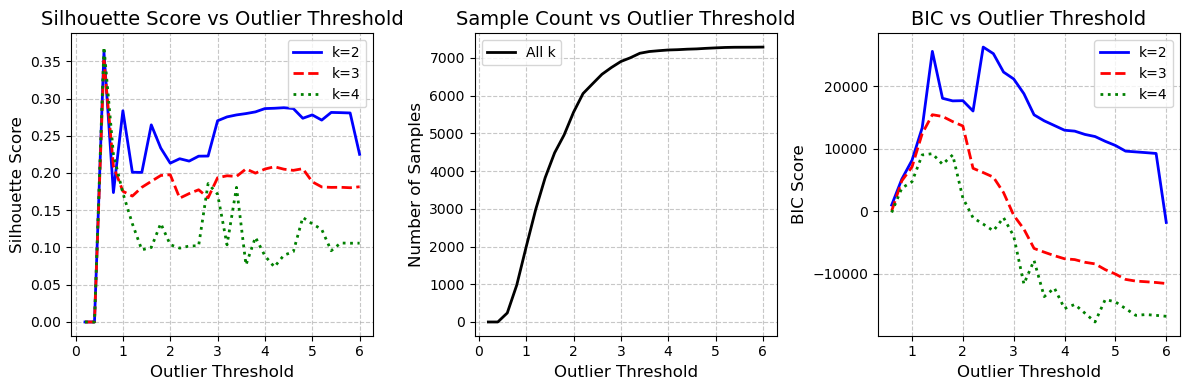


For k=2:
Best outlier threshold: 0.6000000000000001 with silhouette score: 0.363
Number of samples with best threshold: 239
BIC score with best threshold: 967.1525996787825

For k=3:
Best outlier threshold: 0.6000000000000001 with silhouette score: 0.351
Number of samples with best threshold: 239
BIC score with best threshold: 31.309502257564418

For k=4:
Best outlier threshold: 0.6000000000000001 with silhouette score: 0.369
Number of samples with best threshold: 239
BIC score with best threshold: -227.41893957604316


In [38]:
# Only proceed with clustering if we have data
if len(df_for_clustering) > 0:
    # Create a copy of the data for scaling
    X = df_for_clustering[feature_cols].values
    depth_array = df_for_clustering['depth'].values

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply lower weights to PWVel, PWAmp, and MS
    # Get the indices of PWVel, PWAmp, MS, and standard deviation columns in the feature_cols list
    pwvel_idx = feature_cols.index('PWVel')
    pwamp_idx = feature_cols.index('PWAmp')
    ms_idx = feature_cols.index('MS')
    # ct_std_idx = feature_cols.index('CT_std')
    # r_std_idx = feature_cols.index('R_std')
    # g_std_idx = feature_cols.index('G_std')
    # b_std_idx = feature_cols.index('B_std')
    # lumin_std_idx = feature_cols.index('Lumin_std')
    # r_idx = feature_cols.index('R')
    # g_idx = feature_cols.index('G')
    # b_idx = feature_cols.index('B')
    # lumin_idx = feature_cols.index('Lumin')
    
    # Apply weights to reduce influence of some low-resolution logs in the clustering analysis
    X_scaled[:, pwvel_idx] *= 0.05
    X_scaled[:, pwamp_idx] *= 0.05
    X_scaled[:, ms_idx] *= 0.25
    
    # # Apply lower weights to RGB and Luminance
    # X_scaled[:, r_idx] *= 0.9
    # X_scaled[:, g_idx] *= 0.9
    # X_scaled[:, b_idx] *= 0.9
    # X_scaled[:, lumin_idx] *= 0.9
    
    # # Apply lower weights to standard deviation columns
    # X_scaled[:, ct_std_idx] *= 0.1
    # X_scaled[:, r_std_idx] *= 0.1   
    # X_scaled[:, g_std_idx] *= 0.1
    # X_scaled[:, b_std_idx] *= 0.1
    # X_scaled[:, lumin_std_idx] *= 0.1
else:
    print("Warning: No complete data rows found for the selected features.")
    # Create an empty DataFrame with the necessary columns for downstream code
    df_for_clustering = pd.DataFrame(columns=feature_cols + ['depth', 'cluster_label', 'rock_type'])

# Test different outlier thresholds to find the optimal clustering result

outlier_thresholds = [i * 0.2 for i in range(1, 31)]
silhouette_scores = {k: [] for k in [2, 3, 4]}
bic_values = {k: [] for k in [2, 3, 4]} 
sample_counts = []
cluster_results = {k: [] for k in [2, 3, 4]}

for threshold in outlier_thresholds:
    # Select features and handle missing data
    df_temp = df_merged.dropna(subset=feature_cols).copy()
    
    # Calculate z-scores and filter outliers based on current threshold
    z_scores = stats.zscore(df_temp[feature_cols])
    abs_z_scores = np.abs(z_scores)
    outlier_mask = (abs_z_scores < threshold).all(axis=1)
    df_filtered = df_temp[outlier_mask]
    
    # Store the sample count (only need to do this once per threshold)
    sample_count = len(df_filtered)
    sample_counts.append(sample_count)
    
    # Test each k value
    for k in [2, 3, 4]:
        # Only proceed if we have enough data
        if sample_count > k:
            # Scale the data
            X = df_filtered[feature_cols].values
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            # Apply GMM
            gmm = GaussianMixture(n_components=k, random_state=42)
            labels = gmm.fit_predict(X_scaled)
            
            # Calculate silhouette score and BIC
            sil_score = silhouette_score(X_scaled, labels) if len(np.unique(labels)) > 1 else 0
            silhouette_scores[k].append(sil_score)
            bic_values[k].append(gmm.bic(X_scaled))
            
            # Store the clustering results for later visualization
            cluster_results[k].append({
                'threshold': threshold,
                'X_scaled': X_scaled,
                'labels': labels,
                'silhouette': sil_score,
                'sample_count': sample_count
            })
        else:
            silhouette_scores[k].append(0)
            bic_values[k].append(float('inf'))

# Plot the evaluation metrics in a 1x3 grid
plt.figure(figsize=(12, 4))

# Line styles and colors for different k values
styles = {
    2: ('b-', 'k=2'),
    3: ('r--', 'k=3'),
    4: ('g:', 'k=4')
}

# Silhouette Score vs Outlier Threshold
plt.subplot(1, 3, 1)
for k in [2, 3, 4]:
    style, label = styles[k]
    plt.plot(outlier_thresholds, silhouette_scores[k], style, linewidth=2, label=label)
plt.xlabel('Outlier Threshold', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Outlier Threshold', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Sample Count vs Outlier Threshold
plt.subplot(1, 3, 2)
plt.plot(outlier_thresholds, sample_counts, 'k-', linewidth=2, label='All k')
plt.xlabel('Outlier Threshold', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Sample Count vs Outlier Threshold', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# BIC vs Outlier Threshold
plt.subplot(1, 3, 3)
for k in [2, 3, 4]:
    style, label = styles[k]
    valid_indices = [i for i, bic in enumerate(bic_values[k]) if bic != float('inf')]
    valid_thresholds = [outlier_thresholds[i] for i in valid_indices]
    valid_bics = [bic_values[k][i] for i in valid_indices]
    
    if valid_bics:
        plt.plot(valid_thresholds, valid_bics, style, linewidth=2, label=label)

plt.xlabel('Outlier Threshold', fontsize=12)
plt.ylabel('BIC Score', fontsize=12)
plt.title('BIC vs Outlier Threshold', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

# Print information about the best threshold for each k
for k in [2, 3, 4]:
    if silhouette_scores[k]:
        best_idx = np.argmax(silhouette_scores[k])
        best_threshold = outlier_thresholds[best_idx]
        print(f"\nFor k={k}:")
        print(f"Best outlier threshold: {best_threshold} with silhouette score: {silhouette_scores[k][best_idx]:.3f}")
        print(f"Number of samples with best threshold: {sample_counts[best_idx]}")
        print(f"BIC score with best threshold: {bic_values[k][best_idx] if bic_values[k][best_idx] != float('inf') else 'N/A'}")
    else:
        print(f"\nFor k={k}: No valid clustering results were obtained.")


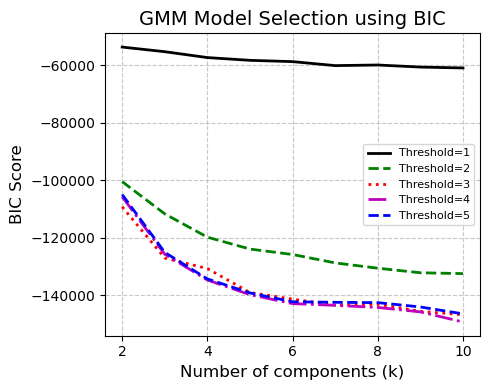

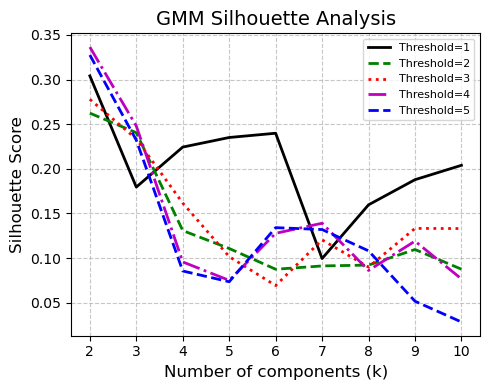


For threshold 1:
Optimal k from likelihood analysis: 4
Best k from silhouette score: 2

For threshold 2:
Optimal k from likelihood analysis: 3
Best k from silhouette score: 2

For threshold 3:
Optimal k from likelihood analysis: 3
Best k from silhouette score: 2

For threshold 4:
Optimal k from likelihood analysis: 3
Best k from silhouette score: 2

For threshold 5:
Optimal k from likelihood analysis: 3
Best k from silhouette score: 2


In [39]:
# Only proceed with clustering if we have data
if len(df_for_clustering) > 0:
    # Create a copy of the data for scaling
    X = df_for_clustering[feature_cols].values
    depth_array = df_for_clustering['depth'].values

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply lower weights to PWVel, PWAmp, and MS
    # Get the indices of PWVel, PWAmp, MS, and standard deviation columns in the feature_cols list
    pwvel_idx = feature_cols.index('PWVel')
    pwamp_idx = feature_cols.index('PWAmp')
    ms_idx = feature_cols.index('MS')
    # ct_std_idx = feature_cols.index('CT_std')
    # r_std_idx = feature_cols.index('R_std')
    # g_std_idx = feature_cols.index('G_std')
    # b_std_idx = feature_cols.index('B_std')
    # lumin_std_idx = feature_cols.index('Lumin_std')
    # r_idx = feature_cols.index('R')
    # g_idx = feature_cols.index('G')
    # b_idx = feature_cols.index('B')
    # lumin_idx = feature_cols.index('Lumin')
    
    # Apply weights to reduce influence of some low-resolution logs in the clustering analysis
    X_scaled[:, pwvel_idx] *= 0.05
    X_scaled[:, pwamp_idx] *= 0.05
    X_scaled[:, ms_idx] *= 0.35
    
    # # Apply lower weights to RGB and Luminance
    # X_scaled[:, r_idx] *= 0.9
    # X_scaled[:, g_idx] *= 0.9
    # X_scaled[:, b_idx] *= 0.9
    # X_scaled[:, lumin_idx] *= 0.9
    
    # # Apply lower weights to standard deviation columns
    # X_scaled[:, ct_std_idx] *= 0.1
    # X_scaled[:, r_std_idx] *= 0.1   
    # X_scaled[:, g_std_idx] *= 0.1
    # X_scaled[:, b_std_idx] *= 0.1
    # X_scaled[:, lumin_std_idx] *= 0.1

# Calculate metrics for GMM with different k values and outlier thresholds
inertias_gmm = []
sil_scores_gmm = []
K_range = range(2, 11)
thresholds = [1, 2, 3, 4, 5]
styles = ['k-','g--', 'r:', 'm-.', 'b--']  # Different line styles for each threshold

# Create dictionaries to store results for each threshold
inertias_by_threshold_gmm = {t: [] for t in thresholds}
sil_scores_by_threshold_gmm = {t: [] for t in thresholds}

# Calculate metrics for each threshold and k
for threshold in thresholds:
    # Apply outlier filtering for this threshold
    z_scores = stats.zscore(X_scaled)
    abs_z_scores = np.abs(z_scores)
    outlier_mask = (abs_z_scores < threshold).all(axis=1)
    X_filtered = X_scaled[outlier_mask]
    
    if len(X_filtered) > 1:  # Ensure we have enough samples
        for k in K_range:
            gmm_temp = GaussianMixture(n_components=k, random_state=42)
            gmm_temp.fit(X_filtered)
            
            # Store BIC score
            inertias_by_threshold_gmm[threshold].append(gmm_temp.bic(X_filtered))
            
            # Store silhouette score if we have enough samples
            if len(X_filtered) > k:
                labels_temp = gmm_temp.predict(X_filtered)
                score = silhouette_score(X_filtered, labels_temp)
                sil_scores_by_threshold_gmm[threshold].append(score)
            else:
                sil_scores_by_threshold_gmm[threshold].append(np.nan)

# Plot BIC curves
plt.figure(figsize=(5,4))
for threshold, style in zip(thresholds, styles):
    if len(inertias_by_threshold_gmm[threshold]) > 0:
        plt.plot(K_range, inertias_by_threshold_gmm[threshold], style, 
                linewidth=2, label=f'Threshold={threshold}')

plt.xlabel("Number of components (k)", fontsize=12)
plt.ylabel("BIC Score", fontsize=12)
plt.title("GMM Model Selection using BIC", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(5,4))
for threshold, style in zip(thresholds, styles):
    if len(sil_scores_by_threshold_gmm[threshold]) > 0:
        plt.plot(K_range, sil_scores_by_threshold_gmm[threshold], style,
                linewidth=2, label=f'Threshold={threshold}')

plt.xlabel("Number of components (k)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("GMM Silhouette Analysis", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Find optimal k for each threshold
for threshold in thresholds:
    if len(inertias_by_threshold_gmm[threshold]) > 0:
        # Calculate the percentage change in negative log likelihood
        inertias = inertias_by_threshold_gmm[threshold]
        inertia_changes = np.diff(inertias) / np.array(inertias[:-1])
        
        # Find where the rate of change slows down significantly
        elbow_candidates = np.where(np.abs(np.diff(inertia_changes)) > np.std(inertia_changes))[0]
        if len(elbow_candidates) > 0:
            optimal_k = K_range[elbow_candidates[0] + 1]
        else:
            # Fallback method
            second_derivative = np.diff(np.diff(inertias))
            optimal_k = K_range[np.argmax(np.abs(second_derivative)) + 2]
            
        # Find best silhouette score
        sil_scores = sil_scores_by_threshold_gmm[threshold]
        best_sil_k = K_range[np.nanargmax(sil_scores)]
        
        print(f"\nFor threshold {threshold}:")
        print(f"Optimal k from likelihood analysis: {optimal_k}")
        print(f"Best k from silhouette score: {best_sil_k}")


	•	Typically, the lower the BIC (Bayesian Information Criterion), the better the fit.

Number of complete rows for clustering: 7349
Number of rows after outlier removal: 7266
GMM Cluster means:
                           CT           R           G           B       Lumin  \
cluster_label_gmm                                                               
0                  614.184385  149.659327  145.796591  110.607099  144.058169   
1                  887.016136  124.761855  121.977866   90.907005  120.328063   
2                  567.605609  139.536683  133.983721  100.827338  132.770086   
3                  708.194684  132.355972  127.792684   97.191606  126.553115   

                    Density         MS     hiresMS        PWVel      PWAmp  
cluster_label_gmm                                                           
0                  1.270538  49.802507   70.763041  1073.020058  13.505591  
1                  1.446628  70.134878  143.683842  1072.561720  11.880135  
2                  1.249043  40.362916   55.974307  1072.676131  13.052381  
3                  1.

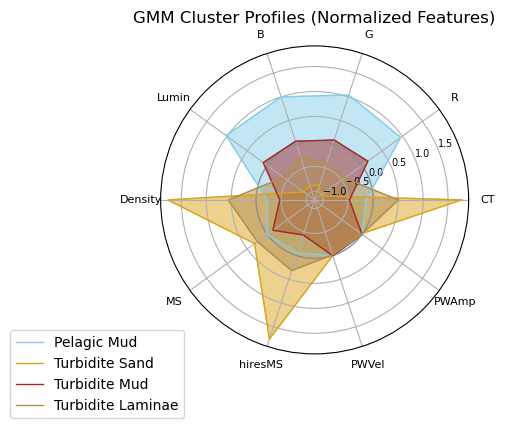

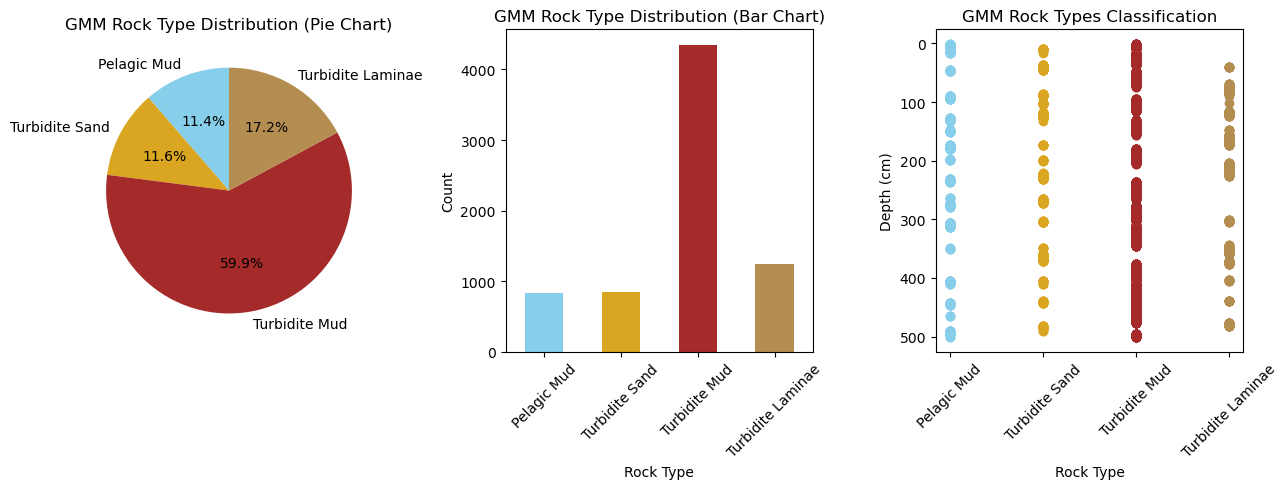

In [40]:
k = 4
best_threshold = 5.0  # You can adjust this threshold value

# Check if there are any rows with complete data for the selected features
df_for_clustering = df_merged.dropna(subset=feature_cols).copy()
print(f"Number of complete rows for clustering: {len(df_for_clustering)}")

# Apply outlier filtering using z-scores
z_scores = stats.zscore(df_for_clustering[feature_cols])
abs_z_scores = np.abs(z_scores)
outlier_mask = (abs_z_scores < best_threshold).all(axis=1)
df_for_clustering = df_for_clustering[outlier_mask]

print(f"Number of rows after outlier removal: {len(df_for_clustering)}")

# Only proceed with clustering if we have data
if len(df_for_clustering) > 0:
    # Create a copy of the data for scaling
    X = df_for_clustering[feature_cols].values
    depth_array = df_for_clustering['depth'].values

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply lower weights to PWVel, PWAmp, and MS
    # Get the indices of PWVel, PWAmp, MS, and standard deviation columns in the feature_cols list
    pwvel_idx = feature_cols.index('PWVel')
    pwamp_idx = feature_cols.index('PWAmp')
    ms_idx = feature_cols.index('MS')
    # ct_std_idx = feature_cols.index('CT_std')
    # r_std_idx = feature_cols.index('R_std')
    # g_std_idx = feature_cols.index('G_std')
    # b_std_idx = feature_cols.index('B_std')
    # lumin_std_idx = feature_cols.index('Lumin_std')
    # r_idx = feature_cols.index('R')
    # g_idx = feature_cols.index('G')
    # b_idx = feature_cols.index('B')
    # lumin_idx = feature_cols.index('Lumin')
    
    # Apply weights to reduce influence of some low-resolution logs in the clustering analysis
    X_scaled[:, pwvel_idx] *= 0.05
    X_scaled[:, pwamp_idx] *= 0.05
    X_scaled[:, ms_idx] *= 0.25
    
    # # Apply lower weights to RGB and Luminance
    # X_scaled[:, r_idx] *= 0.9
    # X_scaled[:, g_idx] *= 0.9
    # X_scaled[:, b_idx] *= 0.9
    # X_scaled[:, lumin_idx] *= 0.9
    
    # Apply lower weights to standard deviation columns
    # X_scaled[:, ct_std_idx] *= 0.05
    # X_scaled[:, r_std_idx] *= 0.05   
    # X_scaled[:, g_std_idx] *= 0.05
    # X_scaled[:, b_std_idx] *= 0.05
    # X_scaled[:, lumin_std_idx] *= 0.05

    # Use the optimal k from previous analysis
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    labels_gmm = gmm.predict(X_scaled)

    df_for_clustering['cluster_label_gmm'] = labels_gmm

    # Calculate cluster means to determine cluster characteristics
    cluster_means_gmm = df_for_clustering.groupby('cluster_label_gmm')[feature_cols].mean()
    print("GMM Cluster means:")
    print(cluster_means_gmm)

    # Determine cluster names based on characteristics
    # Initialize dictionaries for cluster names and colors
    cluster_names_gmm = {}
    cluster_colors_gmm = {}

    # Find the cluster with high hiresMS, density, MS, CT and low RGB/Lumin (Turbidite Sand)
    sand_indicators = ['hiresMS', 'Density', 'MS', 'CT']
    sand_scores = cluster_means_gmm[sand_indicators].mean(axis=1)

    # Find the cluster with high RGB and Lumin (Pelagic Mud)
    pelagic_indicators = ['R', 'G', 'B', 'Lumin']
    pelagic_scores = cluster_means_gmm[pelagic_indicators].mean(axis=1)

    # Assign cluster names based on characteristics
    turbidite_sand_cluster = sand_scores.idxmax()
    pelagic_mud_cluster = pelagic_scores.idxmax()

    # The remaining cluster is Turbidite Mud
    all_clusters = set(range(k))
    assigned_clusters = {turbidite_sand_cluster, pelagic_mud_cluster}
    remaining_clusters = all_clusters - assigned_clusters

    # If we have a conflict (same cluster identified for two types), resolve it
    if len(remaining_clusters) < 1:
        # Re-evaluate using more specific criteria
        # For turbidite sand: high density and CT are most important
        sand_specific = cluster_means_gmm[['Density', 'CT']].mean(axis=1)
        turbidite_sand_cluster = sand_specific.idxmax()
        
        # For pelagic mud: high RGB values are most important
        pelagic_specific = cluster_means_gmm[['R', 'G', 'B']].mean(axis=1)
        pelagic_mud_cluster = pelagic_specific.idxmax()
        
        # Recalculate remaining clusters
        assigned_clusters = {turbidite_sand_cluster, pelagic_mud_cluster}
        remaining_clusters = all_clusters - assigned_clusters

    # Assign names and colors
    cluster_names_gmm[turbidite_sand_cluster] = 'Turbidite Sand'
    cluster_colors_gmm[turbidite_sand_cluster] = 'goldenrod'

    cluster_names_gmm[pelagic_mud_cluster] = 'Pelagic Mud'
    cluster_colors_gmm[pelagic_mud_cluster] = 'skyblue'

    # Assign the remaining cluster as Turbidite Mud
    if remaining_clusters:
        turbidite_mud_cluster = list(remaining_clusters)[0]
        cluster_names_gmm[turbidite_mud_cluster] = 'Turbidite Mud'
        cluster_colors_gmm[turbidite_mud_cluster] = 'brown'

    # For k=4, use a specific color for turbidite laminae
    if k == 4:
        for i in list(all_clusters):
            if i not in cluster_names_gmm:
                cluster_names_gmm[i] = f'Turbidite Laminae'
                # Mix of brown and skyblue
                cluster_colors_gmm[i] = '#B38E50'  # A color between goldenrod and brown
    
    # For k>4, additional clusters get numbered names and random colors
    elif k > 4:
        for i in list(all_clusters):
            if i not in cluster_names_gmm:
                cluster_names_gmm[i] = f'Cluster {i}'
                r = random.random()
                g = random.random()
                b = random.random()
                cluster_colors_gmm[i] = (r, g, b)

    # Add cluster names to the dataframe
    df_for_clustering['rock_type_gmm'] = df_for_clustering['cluster_label_gmm'].map(cluster_names_gmm)

    print("\nGMM Cluster distribution:")
    for cluster_id, name in cluster_names_gmm.items():
        count = (df_for_clustering['cluster_label_gmm'] == cluster_id).sum()
        print(f"{cluster_id} - {name}: {count}")

    # Visualize cluster characteristics with a radar chart
    plt.figure(figsize=(5, 4))
    cluster_centers = gmm.means_

    # Get feature names for the radar chart
    feature_names = feature_cols

    # Number of variables
    N = len(feature_names)

    # Create angles for each feature
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Create the plot
    ax = plt.subplot(111, polar=True)

    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], feature_names, size=8)

    # Set ytick labels to x-small font size
    plt.yticks(size='x-small')

    # Add a darker line for 0.0
    ax.plot(np.linspace(0, 2*np.pi, 100), [0]*100, color='gray', linewidth=1.0, linestyle='-', alpha=0.7)

    # Draw the cluster profiles
    for i in range(k):
        values = cluster_centers[i].tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=1.0, linestyle='solid', label=cluster_names_gmm[i], color=cluster_colors_gmm[i])
        ax.fill(angles, values, alpha=0.5, color=cluster_colors_gmm[i])

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("GMM Cluster Profiles (Normalized Features)")
    plt.show()

    # Visualize GMM cluster distribution
    plt.figure(figsize=(13, 5))

    # Plot 1: Pie chart of GMM cluster distribution
    plt.subplot(1, 3, 1)
    cluster_counts_gmm = df_for_clustering['cluster_label_gmm'].value_counts().sort_index()
    colors_gmm = [cluster_colors_gmm[i] for i in range(k)]
    plt.pie(cluster_counts_gmm, labels=[f'{cluster_names_gmm[i]}' for i in range(k)], 
            autopct='%1.1f%%', startangle=90, colors=colors_gmm)
    plt.title('GMM Rock Type Distribution (Pie Chart)')

    # Plot 2: Bar chart of GMM cluster distribution
    plt.subplot(1, 3, 2)
    cluster_counts_gmm.plot(kind='bar', color=colors_gmm)
    plt.title('GMM Rock Type Distribution (Bar Chart)')
    plt.xlabel('Rock Type')
    plt.ylabel('Count')
    plt.xticks(range(k), [f'{cluster_names_gmm[i]}' for i in range(k)], rotation=45)

    # Plot 3: Depth vs GMM Cluster visualization
    plt.subplot(1, 3, 3)

    # Create a scatter plot with consistent colors
    for cluster_id in range(k):
        cluster_data = df_for_clustering[df_for_clustering['cluster_label_gmm'] == cluster_id]
        plt.scatter([cluster_id] * len(cluster_data), cluster_data['depth'],
                   color=cluster_colors_gmm[cluster_id], label=cluster_names_gmm[cluster_id])

    plt.gca().invert_yaxis()
    plt.title(f"GMM Rock Types Classification")
    plt.xlabel("Rock Type")
    plt.ylabel("Depth (cm)")

    plt.xticks(range(k), [f'{cluster_names_gmm[i]}' for i in range(k)], rotation=45)

    plt.tight_layout()
    plt.show()

You can then visualize cluster_label_gmm the same way you did for K-Means.

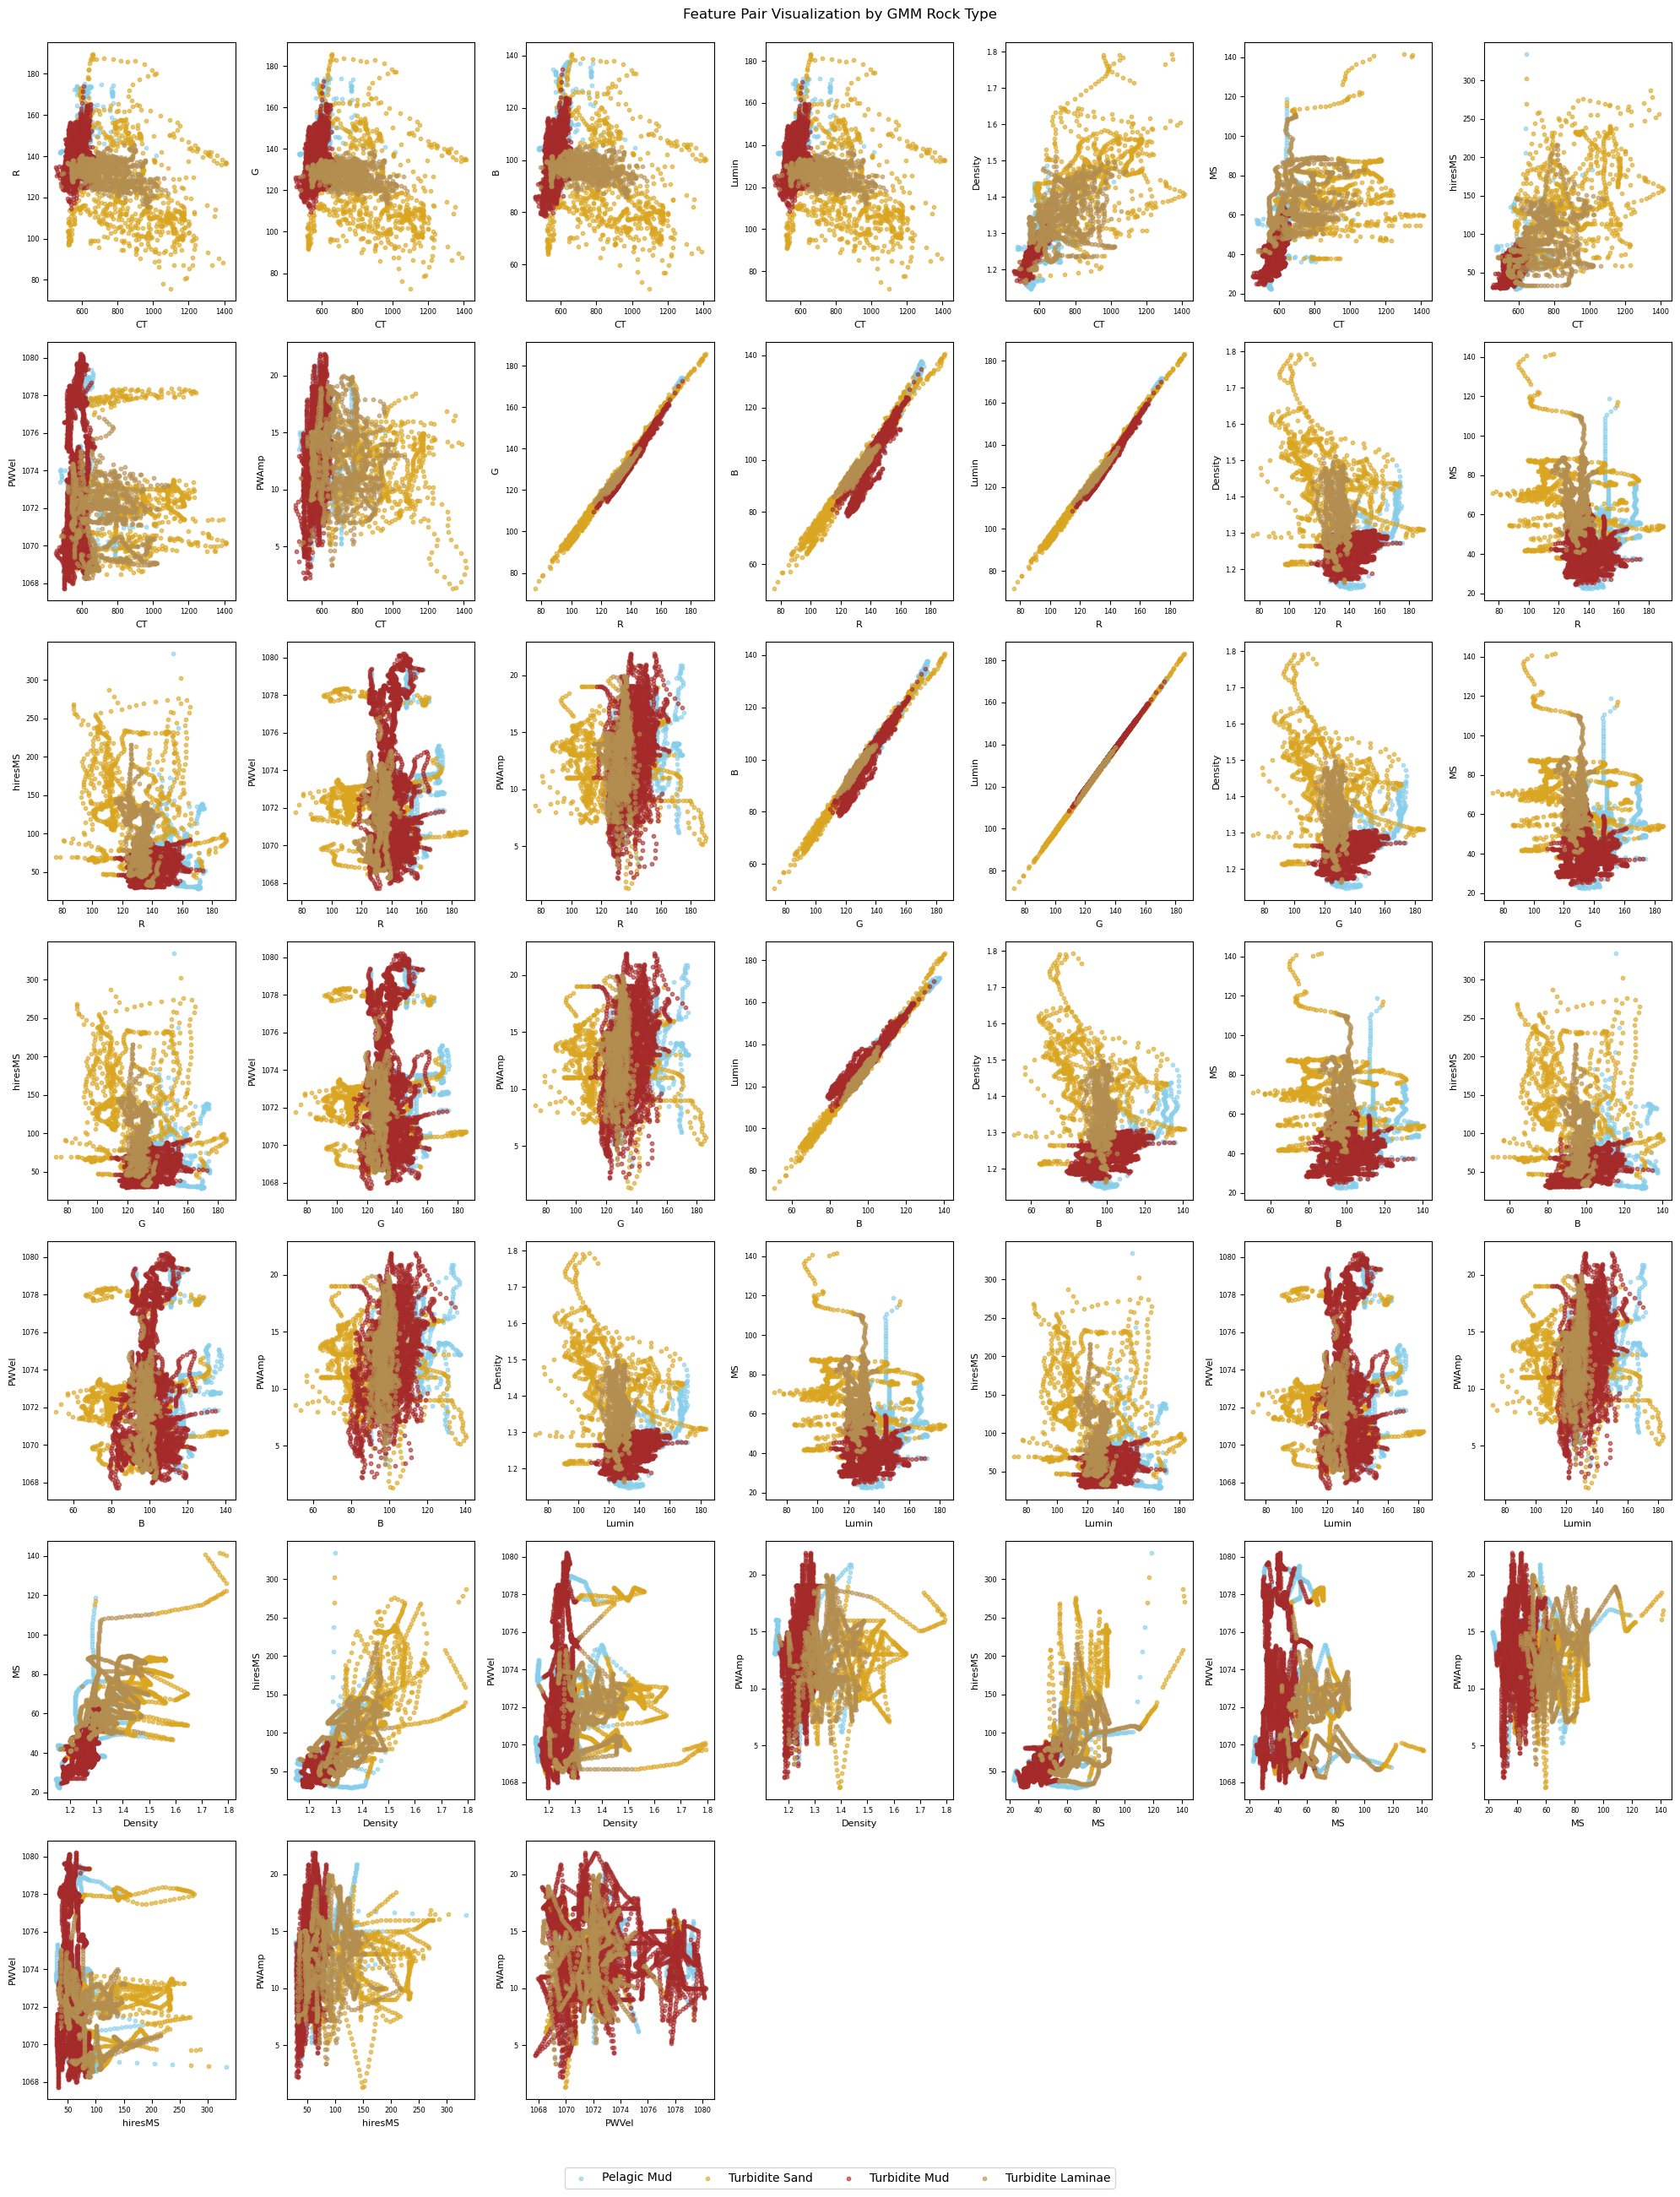

In [41]:
# Create individual feature plots to visualize GMM cluster separation
if len(df_for_clustering) > 0:
    # Use all features for visualization
    vis_features = feature_cols
    
    # Calculate number of feature pairs
    n_features = len(vis_features)
    n_pairs = n_features * (n_features - 1) // 2  # Number of unique pairs
    
    # Calculate number of rows and columns for subplots
    n_cols = 7 # You can adjust this for layout
    n_rows = (n_pairs + n_cols - 1) // n_cols
    
    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 25))
    
    # Flatten axes array for easier indexing
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    # Plot each feature pair
    plot_idx = 0
    for i in range(n_features):
        for j in range(i+1, n_features):
            if plot_idx < len(axes):
                ax = axes[plot_idx]
                
                # Get feature names for this pair
                feat_x = vis_features[i]
                feat_y = vis_features[j]
                
                # Scatter plot of feature pair
                for cluster_id in range(k):
                    cluster_points = df_for_clustering[df_for_clustering['cluster_label_gmm'] == cluster_id]
                    ax.scatter(cluster_points[feat_x], cluster_points[feat_y], 
                              s=10, alpha=0.6, color=cluster_colors_gmm[cluster_id], 
                              label=cluster_names_gmm[cluster_id])
                
                # Set labels
                ax.set_xlabel(feat_x, fontsize=8)
                ax.set_ylabel(feat_y, fontsize=8)
                ax.tick_params(axis='both', which='major', labelsize=6)
                
                plot_idx += 1
    
    # Hide any unused subplots
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    # Add a single legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    # Place legend outside the figure at the bottom
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=k)
    
    # Adjust figure margins to make room for the legend
    plt.subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.suptitle("Feature Pair Visualization by GMM Rock Type", y=1.01)
    plt.show()


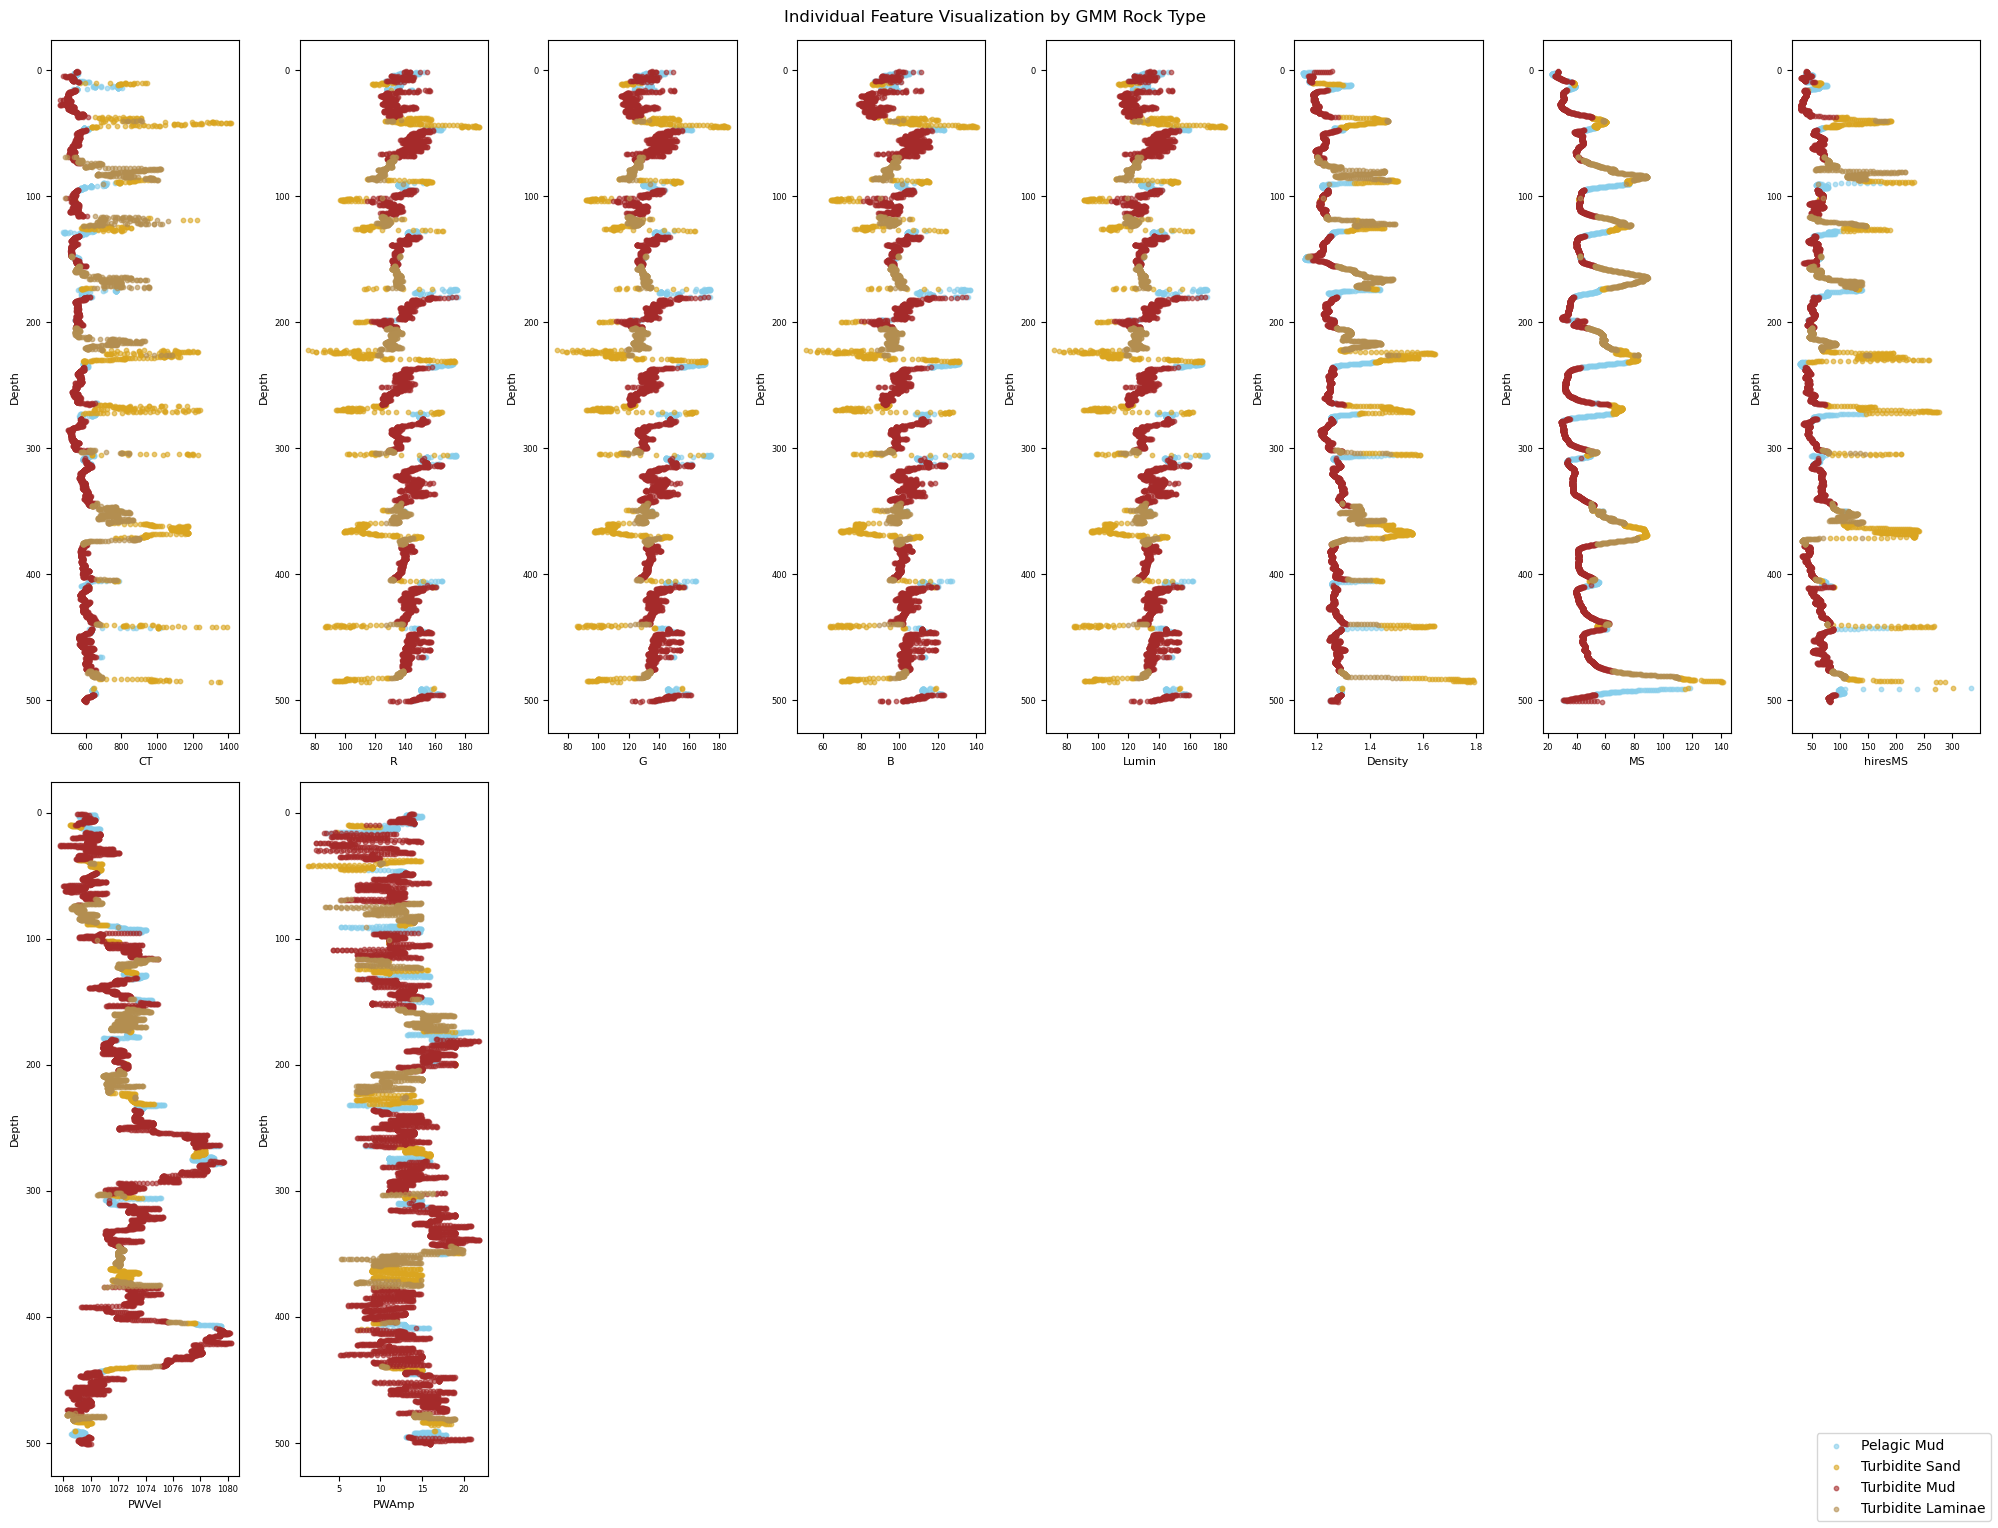

In [42]:
# 3. Create individual feature plots to visualize GMM cluster separation
if len(df_for_clustering) > 0:
    # Use all features for visualization
    vis_features = feature_cols
    
    # Calculate number of rows and columns for subplots
    n_features = len(vis_features)
    n_cols = 8  # You can adjust this for layout
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
    
    # Flatten axes array for easier indexing
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    # Plot each feature
    for i, feat in enumerate(vis_features):
        if i < len(axes):
            ax = axes[i]
            
            # Scatter plot of feature vs depth
            for cluster_id in range(k):
                cluster_points = df_for_clustering[df_for_clustering['cluster_label_gmm'] == cluster_id]
                ax.scatter(cluster_points[feat], cluster_points['depth'], 
                          s=10, alpha=0.6, color=cluster_colors_gmm[cluster_id], 
                          label=cluster_names_gmm[cluster_id])
            
            # Set labels
            ax.set_xlabel(feat, fontsize=8)
            ax.set_ylabel('Depth', fontsize=8)
            ax.tick_params(axis='both', which='major', labelsize=6)
            ax.invert_yaxis()  # Invert y-axis for depth
    
    # Hide any unused subplots
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    # Add a single legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right', ncol=1)
    
    plt.tight_layout()
    plt.suptitle("Individual Feature Visualization by GMM Rock Type", y=1.01)
    plt.show()


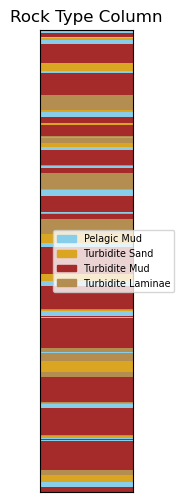

In [43]:
df_for_clustering_sorted = df_for_clustering.sort_values(by='depth').reset_index(drop=True)
depth_vals = df_for_clustering_sorted['depth'].values
labels_vals = df_for_clustering_sorted['cluster_label_gmm'].values

fig, ax = plt.subplots(figsize=(1.2,6))

# Use the same cluster colors defined earlier
colors = [cluster_colors_gmm[i] for i in range(k)]

for i in range(len(depth_vals)-1):
    top = depth_vals[i]
    bottom = depth_vals[i+1]
    c_label = labels_vals[i]
    color = cluster_colors_gmm[c_label]
    ax.add_patch(
        mpatches.Rectangle((0, top), 1, bottom - top,
                           facecolor=color, edgecolor='none')
    )

# Add a legend showing rock types
handles = [mpatches.Patch(color=cluster_colors_gmm[i], label=cluster_names[i]) for i in range(k)]
ax.legend(handles=handles, loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize='x-small')

ax.set_ylim([depth_vals.max(), depth_vals.min()])
ax.set_xlim([0, 1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Rock Type Column")
plt.show()

In [44]:
def plot_core_logs(data_paths, column_configs, core_length, ct_img=None, rgb_img=None, title='Combined Logs', cluster_data=None):
    """
    Plot core logs from multiple data sources.
    
    Args:
        data_paths (dict): Dictionary containing paths to data files
            e.g. {a
                'ct': 'path/to/ct.csv',
                'rgb': 'path/to/rgb.csv', 
                'mst': 'path/to/mst.csv',
                'hrms': 'path/to/hrms.csv'
            }
        column_configs (dict): Configuration for columns to plot
            e.g. {
                'ct': {'data_col': 'CT', 'std_col': 'CT_std', 'depth_col': 'SB_DEPTH_cm'},
                'rgb': {'data_cols': ['R','G','B'], 'std_cols': ['R_std','G_std','B_std'], 'depth_col': 'SB_DEPTH_cm'},
                'mst': {
                    'density': {'data_col': 'Den_gm/cc', 'depth_col': 'SB_DEPTH_cm'},
                    'pwvel': {'data_col': 'PWVel_m/s', 'depth_col': 'SB_DEPTH_cm'},
                    'pwamp': {'data_col': 'PWAmp', 'depth_col': 'SB_DEPTH_cm'},
                    'elecres': {'data_col': 'ElecRes_ohmm', 'depth_col': 'SB_DEPTH_cm'},
                    'ms': {'data_col': 'MS', 'depth_col': 'SB_DEPTH_cm'}
                },
                'hrms': {'data_col': 'hiresMS', 'depth_col': 'SB_DEPTH_cm'}
            }
        core_length (float): Length of the core in cm
        ct_img (array, optional): CT image array
        rgb_img (array, optional): RGB image array
        title (str): Title for the plot
        cluster_data (dict, optional): Dictionary containing cluster data
            e.g. {
                'depth_vals': depth_values_array,
                'labels_vals': cluster_labels_array,
                'k': number_of_clusters
            }
    """
    # Load data
    data = {}
    for key, path in data_paths.items():
        if path:
            data[key] = pd.read_csv(path)
            if 'SB_DEPTH_cm' not in data[key].columns:
                raise ValueError(f"SB_DEPTH_cm column missing in {key} data")
    
    # Calculate number of plots needed
    n_plots = 0  # Start with 0
    
    # Add cluster column if cluster data exists
    if cluster_data is not None:
        n_plots += 1
    
    # Add CT panels if CT image and data exist
    if ct_img is not None and 'ct' in data:
        n_plots += 2  # CT image and data
        
    # Add RGB panels if RGB image and data exist  
    if rgb_img is not None and 'rgb' in data:
        n_plots += 2  # RGB image and data
        
    # Add MS panel if either MST MS data or hiresMS data exists and has data
    if ('mst' in data and column_configs['mst']['ms']['data_col'] in data['mst'].columns and not data['mst'][column_configs['mst']['ms']['data_col']].isna().all()) or ('hrms' in data and not data['hrms'][column_configs['hrms']['data_col']].isna().all()):
        n_plots += 1
        
    # Add panels for other MST logs that exist and have data
    if 'mst' in data:
        for log_type, config in column_configs['mst'].items():
            if log_type != 'ms':  # Skip MS since it's handled separately
                if config['data_col'] in data['mst'].columns and not data['mst'][config['data_col']].isna().all():
                    n_plots += 1

    if n_plots == 0:
        raise ValueError("No valid data to plot")
    
    # Create figure and axes
    fig, axes = plt.subplots(1, n_plots, figsize=(10, 16), sharey=True)
    if n_plots == 1:
        axes = [axes]  # Ensure axes is iterable
    fig.suptitle(title, fontweight='bold')
    
    current_ax = 0
    
    # ---------------------------
    # Plot Cluster Column if available
    # ---------------------------
    if cluster_data is not None:
        depth_vals = cluster_data['depth_vals']
        labels_vals = cluster_data['labels_vals']
        k = cluster_data['k']
        
        # Use the same cluster colors defined earlier
        colors = [cluster_colors_gmm[i] for i in range(k)]
        
        for i in range(len(depth_vals)-1):
            top = depth_vals[i]
            bottom = depth_vals[i+1]
            c_label = labels_vals[i]
            color = cluster_colors_gmm[c_label]
            axes[current_ax].add_patch(
                mpatches.Rectangle((0, top), 1, bottom - top,
                                  facecolor=color, edgecolor='none')
            )
        
        # Add a legend showing rock types
        handles = [mpatches.Patch(color=cluster_colors_gmm[i], label=cluster_names[i]) for i in range(k)]
        axes[current_ax].legend(handles=handles, loc='center right', fontsize='x-small')
        
        axes[current_ax].set_ylim([depth_vals.max(), depth_vals.min()])
        axes[current_ax].set_xlim([0, 1])
        axes[current_ax].set_xticks([])
        axes[current_ax].set_xlabel('Rock Type\nColumn', fontweight='bold', fontsize='small')
        current_ax += 1
    
    # ---------------------------
    # Plot CT image and data
    # ---------------------------
    if ct_img is not None and 'ct' in data:
        # Plot CT image
        axes[current_ax].imshow(ct_img, aspect='auto', extent=[0, 0.5, core_length, 0])
        axes[current_ax].set_ylabel('Depth (cm)')
        axes[current_ax].set_xticks([])
        axes[current_ax].set_xlabel('Sediment\nCore\nCT Scan', fontweight='bold', fontsize='small')
        current_ax += 1
        
        # Plot CT data
        ct_col = column_configs['ct']['data_col']
        ct_std = column_configs['ct']['std_col']
        ct_depth = data['ct'][column_configs['ct']['depth_col']].astype(np.float64)
        
        axes[current_ax].plot(data['ct'][ct_col].astype(np.float64), ct_depth, 
                              color='black', linewidth=0.7)
        
        # Standard deviation fill
        axes[current_ax].fill_betweenx(
            ct_depth,
            data['ct'][ct_col].astype(np.float64) - data['ct'][ct_std].astype(np.float64),
            data['ct'][ct_col].astype(np.float64) + data['ct'][ct_std].astype(np.float64),
            color='black', alpha=0.2, linewidth=0
        )
        
        # Color-coded CT values using PolyCollection
        ct_values = data['ct'][ct_col].astype(np.float64).values
        depths = ct_depth.values
        norm = plt.Normalize(300, 1600)
        cmap = plt.cm.jet
        
        ct_polys = []
        ct_facecolors = []
        for i in range(len(depths) - 1):
            # Ignore segments with NaN values
            if not (np.isnan(ct_values[i]) or np.isnan(ct_values[i+1])):
                poly = [
                    (0, depths[i]),
                    (ct_values[i], depths[i]),
                    (ct_values[i+1], depths[i+1]),
                    (0, depths[i+1])
                ]
                ct_polys.append(poly)
                # Use the average value for smoother color transition
                avg_val = (ct_values[i] + ct_values[i+1]) / 2
                ct_facecolors.append(cmap(norm(avg_val)))
                
        if ct_polys:
            import matplotlib.collections as mcoll
            pc_ct = mcoll.PolyCollection(ct_polys, facecolors=ct_facecolors, edgecolors='none', alpha=0.95)
            axes[current_ax].add_collection(pc_ct)
        
        axes[current_ax].set_xlabel('CT#\nBrightness', fontweight='bold', fontsize='small')
        axes[current_ax].grid(True)
        axes[current_ax].set_xlim(300, None)
        axes[current_ax].tick_params(axis='x', labelsize='x-small')
        current_ax += 1
    
    # ---------------------------
    # Plot RGB image and data
    # ---------------------------
    if rgb_img is not None and 'rgb' in data:
        # Plot RGB image
        axes[current_ax].imshow(rgb_img, aspect='auto', extent=[0, 0.5, core_length, 0])
        axes[current_ax].set_xticks([])
        axes[current_ax].set_xlabel('Sediment\nCore\nPhoto', fontweight='bold', fontsize='small')
        current_ax += 1
        
        # Plot RGB data (R, G, B channels)
        rgb_cols = column_configs['rgb']['data_cols']
        rgb_stds = column_configs['rgb']['std_cols']
        rgb_depth = data['rgb'][column_configs['rgb']['depth_col']].astype(np.float64)
        colors = ['red', 'green', 'blue']
        
        for col, std, color in zip(rgb_cols[:3], rgb_stds[:3], colors):
            axes[current_ax].plot(data['rgb'][col].astype(np.float64), rgb_depth,
                                  color=color, linewidth=0.7)
            axes[current_ax].fill_betweenx(
                rgb_depth,
                data['rgb'][col].astype(np.float64) - data['rgb'][std].astype(np.float64),
                data['rgb'][col].astype(np.float64) + data['rgb'][std].astype(np.float64),
                color=color, alpha=0.2, linewidth=0
            )
        
        # Luminance plot using PolyCollection with Inferno colormap
        lumin_values = data['rgb']['Lumin'].astype(np.float64).values
        lumin_depths = rgb_depth.values
        
        # Compute normalization range ignoring NaNs
        valid_lumin = lumin_values[~np.isnan(lumin_values)]
        if len(valid_lumin) == 0:
            vmin, vmax = 0, 1
        else:
            vmin, vmax = valid_lumin.min(), valid_lumin.max()
            if np.isclose(vmin, vmax):
                vmin, vmax = 0, 1
        
        lumin_norm = plt.Normalize(vmin, vmax)
        cmap_inferno = plt.cm.inferno
        
        lumin_polys = []
        lumin_facecolors = []
        for i in range(len(lumin_depths) - 1):
            # Only use segments with valid (non-NaN) endpoints
            if not (np.isnan(lumin_values[i]) or np.isnan(lumin_values[i+1])):
                poly = [
                    (0, lumin_depths[i]),
                    (lumin_values[i], lumin_depths[i]),
                    (lumin_values[i+1], lumin_depths[i+1]),
                    (0, lumin_depths[i+1])
                ]
                lumin_polys.append(poly)
                # Use average value for color mapping
                avg_val = (lumin_values[i] + lumin_values[i+1]) / 2
                lumin_facecolors.append(cmap_inferno(lumin_norm(avg_val)))
        if lumin_polys:
            import matplotlib.collections as mcoll
            pc_lumin = mcoll.PolyCollection(lumin_polys, facecolors=lumin_facecolors, edgecolors='none', alpha=0.95)
            axes[current_ax].add_collection(pc_lumin)
        
        axes[current_ax].set_xlabel('RGB\nLuminance', fontweight='bold', fontsize='small')
        axes[current_ax].grid(True)
        axes[current_ax].tick_params(axis='x', labelsize='x-small')
        current_ax += 1
    
    # ---------------------------
    # Plot MS and MST data if available
    # ---------------------------
    if 'mst' in data:
        # Plot MS data if available
        ms_col = column_configs['mst']['ms']['data_col']
        has_mst_ms = 'mst' in data and ms_col in data['mst'].columns and not data['mst'][ms_col].isna().all()
        has_hrms = 'hrms' in data and not data['hrms'][column_configs['hrms']['data_col']].isna().all()

        if has_mst_ms or has_hrms:
            if has_mst_ms:
                axes[current_ax].plot(
                    data['mst'][ms_col].astype(np.float64), 
                    data['mst'][column_configs['mst']['ms']['depth_col']].astype(np.float64),
                    color='darkgray', label='Lo-res', linewidth=0.7
                )
            if has_hrms:
                axes[current_ax].plot(
                    data['hrms'][column_configs['hrms']['data_col']].astype(np.float64), 
                    data['hrms'][column_configs['hrms']['depth_col']].astype(np.float64),
                    color='black', label='Hi-res', linewidth=0.7
                )
            axes[current_ax].tick_params(axis='x', labelsize='x-small')
            axes[current_ax].set_xlabel('Magnetic\nSusceptibility', fontweight='bold')
            axes[current_ax].grid(True)
            current_ax += 1

        # Plot remaining MST logs that have data
        mst_labels = {
            'density': 'Density\n(g/cc)',
            'pwvel': 'P-wave\nVelocity\n(m/s)',
            'pwamp': 'P-wave\nAmplitude',
            'elecres': 'Electrical\nResistivity\n(ohm-m)'
        }
        
        mst_colors = {
            'density': 'orange',
            'pwvel': 'purple',
            'pwamp': 'purple',
            'elecres': 'brown'
        }

        for log_type, config in column_configs['mst'].items():
            if log_type != 'ms' and config['data_col'] in data['mst'].columns and not data['mst'][config['data_col']].isna().all():
                axes[current_ax].plot(
                    data['mst'][config['data_col']].astype(np.float64), 
                    data['mst'][config['depth_col']].astype(np.float64), 
                    color=mst_colors.get(log_type, 'black'), 
                    linewidth=0.7
                )
                axes[current_ax].set_xlabel(mst_labels[log_type], fontweight='bold', fontsize='small')
                axes[current_ax].tick_params(axis='x', labelsize='x-small')
                axes[current_ax].grid(True)
                if log_type == 'density':
                    axes[current_ax].set_xlim(1, 2)
                current_ax += 1
    
    # ---------------------------
    # Set common y-axis properties
    # ---------------------------
    for ax in axes:
        ax.invert_yaxis()
        ax.set_ylim(core_length, 0)
    
    plt.tight_layout()
    return fig, axes

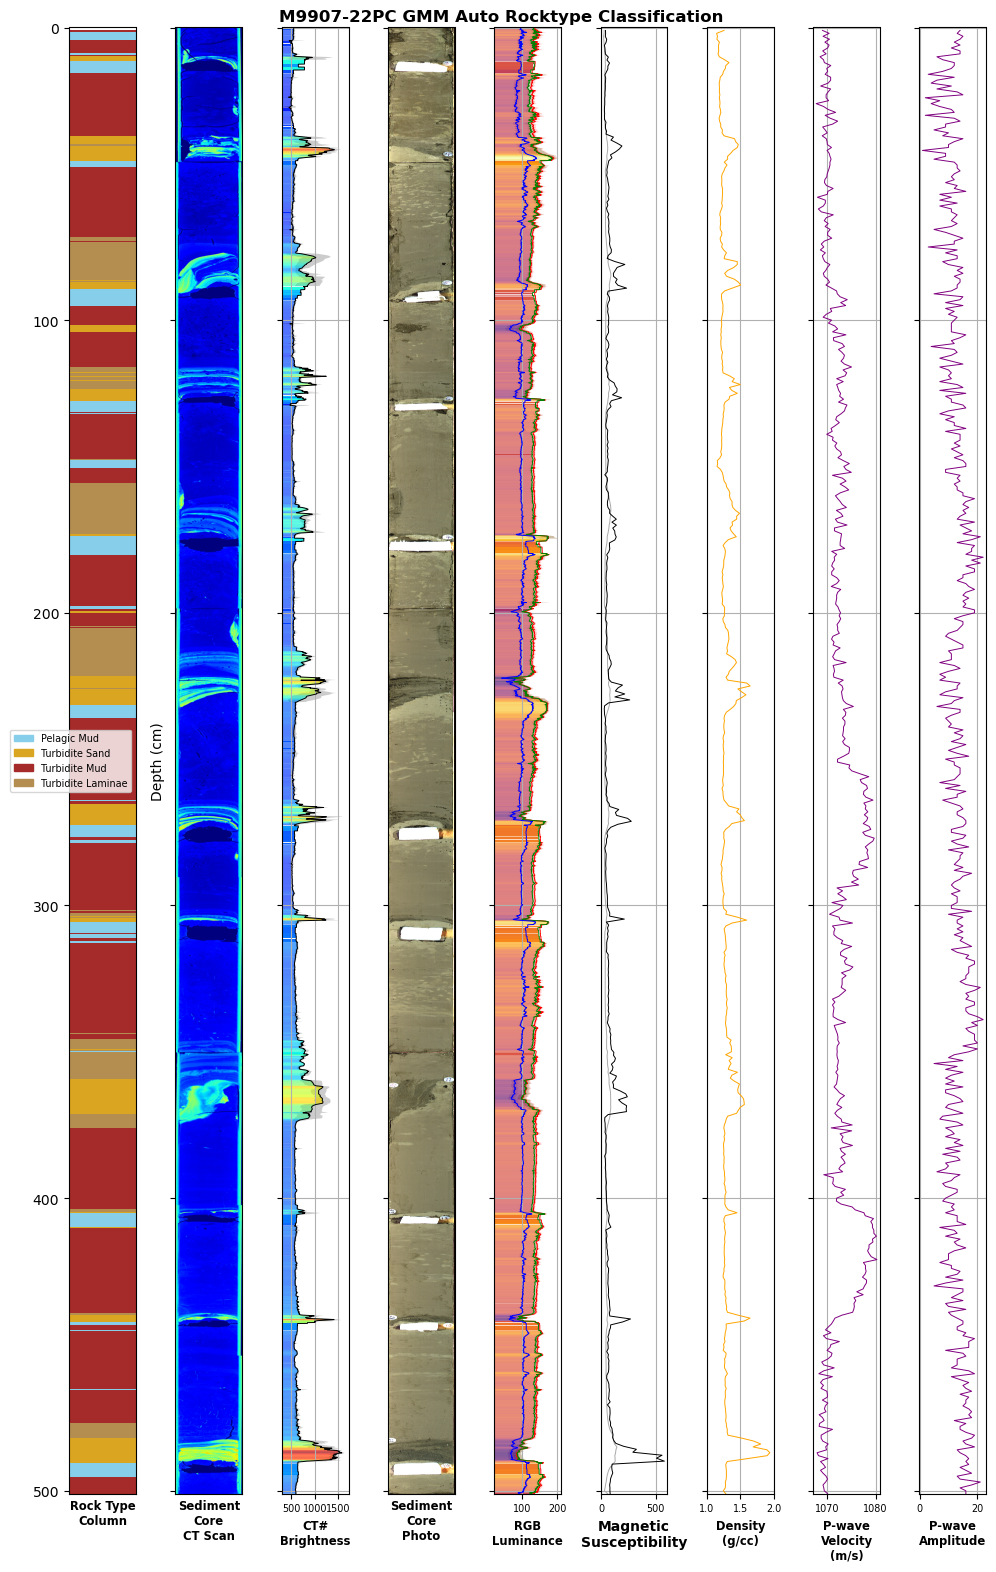

In [45]:
# Plot processed/cleaned logs
plt_title = f'{core_name} GMM Auto Rocktype Classification'

# Create cluster data dictionary for the plot_core_logs function
cluster_data = {
    'depth_vals': df_for_clustering_sorted['depth'].values,
    'labels_vals': df_for_clustering_sorted['cluster_label_gmm'].values,
    'k': k
}

fig, axes = plot_core_logs(filled_data_paths, column_configs, core_length, ct_img, rgb_img, 
                          title=plt_title, cluster_data=cluster_data)
plt.show()

<hr>

# Exporting Cluster-Labeled Data Back to CSV

Finally, you can save your augmented DataFrame to CSV for further analysis or plotting in other software:

In [46]:
# output_path = mother_dir + '_compiled_logs/' + core_name + '/' + core_name + '_clustered.csv'
# df_for_clustering.to_csv(output_path, index=False)
# print(f"Cluster-labeled data saved to {output_path}")

If you run multiple models (e.g., both K-Means and GMM), you might have two cluster-label columns. You can keep both to compare or export them as separate files.